## Preamble 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

In [3]:
#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
SMFF = '/Users/Ismael/code/lensing/SMFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

In [4]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [5]:
def plot_matrix(matrix, param_names): 

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    n,_ = matrix.shape #assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)
    
    plt.tick_params(labelsize=20)


    ax.matshow(matrix, cmap=plt.cm.Blues)


    for i in xrange(n):
        for j in xrange(n):
            c = matrix[j,i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center',size=20)

In [6]:
#gets the ids of the galaxies that is contained in each cat in cats and returns a new list new_cats 
#that contains only this galaxies
def get_intersection_cats(cats,other_cats=False): 
    intersection = set() 
    for i,cat in enumerate(cats): 
        if i==0: 
            intersection = set(cat['db_id']) 
        intersection = intersection.intersection(cat['db_id'])
            
    #convert intersection ids to indices , then remove indices that are not those ones:
    new_cats = []
    new_non_cats = [] 
    for cat in cats: 
        bool_slice = []
        for id_gal in cat['db_id']: 
            bool_slice.append(id_gal in intersection)
        new_cats.append(cat[bool_slice])
        new_non_cats.append(cat[np.invert(bool_slice)])
        
    if other_cats: 
        return new_cats,new_non_cats
    else: 
        return new_cats




## Simulate a single chip 

In [5]:
#to simulate the following files need whole weaklensing deblending package to run.
#need OneDegSq.fits, found in ftp://ftp.slac.stanford.edu/groups/desc/WL/

In [7]:
os.chdir('/Users/Ismael/code/lensing/WeakLensingDeblending/')

In [ ]:
filename = ''
section_name = 'section-{}.fits'.format(filename)

noise_iamge = 'noise_image.fits'
table_file = 'table.fits'


In [10]:
cosmic_shear_g1 = 0. 
cosmic_shear_g2 = 0. 
job_number = 1
i,j = 0,0
image_width = 4500
image_height = 4500

In [12]:
cmd = './simulate.py --catalog-name OneDegSq.fits --survey-name LSST --image-width {} --image-height {} --output-name section-{}{}{} --calculate-bias --cosmic-shear-g1 {} --cosmic-shear-g2 {} --verbose'.format(image_width,image_height,i,j,job_number,cosmic_shear_g1,cosmic_shear_g2)
os.system(cmd)

256

In [ ]:
noise_seed = 0
#get image
fits_section = fitsio.FITS(file_name)
stamp = fits_section[0].read()


reader = descwl.output.Reader(section_name)
results = reader.results
generator = galsim.random.BaseDeviate(seed = noise_seed)
noise = galsim.PoissonNoise(rng = generator, sky_level = results.survey.mean_sky_level)
full_stamp_galsim = galsim.Image(array=stamp,wcs=galsim.PixelScale(pixel_scale),bounds=galsim.BoundsI(xmin=0, xmax=total_width-1, ymin=0, ymax=total_height-1)
full_stamp_galsim.addNoise(noise)

                                 
f = fits.PrimaryHDU(full_stamp_galsim.array)
f.writeto(inputs_slac['noise_image'])

## Get output with the following command (takes a long time and better to run in SLAC). 

In [6]:
#this is for the 5 final fits files. 
#the file to use is all-process.py (found in the folder WeakLensingDeblending/jobs)
#under the assumption you are currently logged in SLAC. 
cmds= [
"python all-process.py --simulate --job-number 1 --cosmic-shear-g1 0. --cosmic-shear-g2 0. --noise-seed 0"
"python all-process.py --simulate --job-number 2 --cosmic-shear-g1 0.01 --cosmic-shear-g2 0.01 --noise-seed 0"
"python all-process.py --simulate --job-number 3 --cosmic-shear-g1 -0.01 --cosmic-shear-g2 -0.01 --noise-seed 0"
"python all-process.py --simulate --job-number 4 --cosmic-shear-g1 0.02 --cosmic-shear-g2 0.02 --noise-seed 0"
"python all-process.py --simulate --job-number 5 --cosmic-shear-g1 -0.02 --cosmic-shear-g2 -0.02 --noise-seed 0"

"python all-process.py --combine --job-number 1 --cosmic-shear-g1 0. --cosmic-shear-g2 0. --noise-seed 0"
"python all-process.py --combine --job-number 2 --cosmic-shear-g1 0.01 --cosmic-shear-g2 0.01 --noise-seed 0"
"python all-process.py --combine --job-number 3 --cosmic-shear-g1 -0.01 --cosmic-shear-g2 -0.01 --noise-seed 0"
"python all-process.py --combine --job-number 4 --cosmic-shear-g1 0.02 --cosmic-shear-g2 0.02 --noise-seed 0"
"python all-process.py --combine --job-number 5 --cosmic-shear-g1 -0.02 --cosmic-shear-g2 -0.02 --noise-seed 0"

"python all-process.py --extract --job-number 1 --cosmic-shear-g1 0. --cosmic-shear-g2 0. --noise-seed 0"
"python all-process.py --extract --job-number 2 --cosmic-shear-g1 0.01 --cosmic-shear-g2 0.01 --noise-seed 0"
"python all-process.py --extract --job-number 3 --cosmic-shear-g1 -0.01 --cosmic-shear-g2 -0.01 --noise-seed 0"
"python all-process.py --extract --job-number 4 --cosmic-shear-g1 0.02 --cosmic-shear-g2 0.02 --noise-seed 0"
"python all-process.py --extract --job-number 5 --cosmic-shear-g1 -0.02 --cosmic-shear-g2 -0.02 --noise-seed 0"


]

## Prepare input 

In [7]:
#files , the order is as follows 
#g1,g2=0,0
#g1,g2=.01,.01
#g1,g2=-.01,-.01
#g1,g2=.02,.02
#g1,g2=-.02,-.02
#respectively. 
files = dict(
final_fitsLSST1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-20/final_fits.fits', 
final_fitsLSST2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-15/final_fits.fits', 
final_fitsLSST3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-10/final_fits.fits', 
final_fitsLSST4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_-5/final_fits.fits', 
final_fitsLSST5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_0/final_fits.fits', 
final_fitsLSST6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_5/final_fits.fits', 
final_fitsLSST7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_10/final_fits.fits', 
final_fitsLSST8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_15/final_fits.fits', 
final_fitsLSST9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectLSST-g1_20/final_fits.fits', 
    
final_fitsDES1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-20/final_fits.fits', 
final_fitsDES2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-15/final_fits.fits', 
final_fitsDES3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-10/final_fits.fits', 
final_fitsDES4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-5/final_fits.fits', 
final_fitsDES5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_0/final_fits.fits', 
final_fitsDES6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_5/final_fits.fits', 
final_fitsDES7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_10/final_fits.fits', 
final_fitsDES8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_15/final_fits.fits', 
final_fitsDES9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_20/final_fits.fits', 
    
final_fitsHSC1 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-20/final_fits.fits', 
final_fitsHSC2 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-15/final_fits.fits', 
final_fitsHSC3 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-10/final_fits.fits', 
final_fitsHSC4 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-5/final_fits.fits', 
final_fitsHSC5 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_0/final_fits.fits', 
final_fitsHSC6 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_5/final_fits.fits', 
final_fitsHSC7 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_10/final_fits.fits', 
final_fitsHSC8 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_15/final_fits.fits', 
final_fitsHSC9 = '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_20/final_fits.fits', 

)

files_temps = dict() 
for f in files: 
    l = files[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    files_temps[f] = temp_file

    
files_slac = dict()
for f in files: 
    l = files[f].split("/")
    index_data = l.index("aegis")
    str_slac = "/".join(l[index_data:])
    slac_file = '{0}{1}'.format('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/',str_slac)
    files_slac[f] = slac_file

In [8]:
files

{'final_fitsDES1': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-20/final_fits.fits',
 'final_fitsDES2': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-15/final_fits.fits',
 'final_fitsDES3': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-10/final_fits.fits',
 'final_fitsDES4': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_-5/final_fits.fits',
 'final_fitsDES5': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_0/final_fits.fits',
 'final_fitsDES6': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_5/final_fits.fits',
 'final_fitsDES7': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_10/final_fits.fits',
 'final_fitsDES8': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_15/final_fits.fits',
 'final_fitsDES9': '/Users/Ismael/aegis/WeakLensingDeblending/projectDES-g1_20/final_fits.fits',
 'final_fitsHSC1': '/Users/Ismael/aegis/WeakLensingDeblending/projectHSC-g1_-20/final_fits.fits',
 'final_fitsHSC2': '/Users/I

## Samples 

In [9]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 5) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

#filter rare (bad) objs. Which will not be good for our purposes. 
not_bad = lambda cat: cat[(cat['snr_grp'] != 0) & (cat['ds_grp']!= inf) ]

In [10]:
def get_non_duplicated_cat(cat):
    #get non-duplicated and duplicated objects
    seen = set()
    duplic = set()
    a = list(cat['db_id'])

    for x in a:
        if x in seen: 
            duplic.add(x)
        if x not in seen:
            seen.add(x)

    #get duplicated objects
    duplic_bool = []
    non_duplic_bool = []
    for x in list(cat['db_id']):
        if x in duplic:
            duplic_bool.append(True)
            non_duplic_bool.append(False)
        else:
            duplic_bool.append(False)
            non_duplic_bool.append(True)
            
    duplic_cat = cat[np.array(duplic_bool)]
    non_duplic_cat = cat[np.array(non_duplic_bool)]  #decided to just remove duplicated 
    
    return non_duplic_cat

In [11]:
#smaller random samples 
def leaveRandom(sz,cat):
    new_cat = deepcopy(cat)
    rm_rows = random.sample(xrange(0,len(cat)-1), len(cat) - sz)
    new_cat.remove_rows(rm_rows)
    return new_cat 

#get a smaller sample of each of the catalogs for illustrative purposes 
small = lambda cat,N: leaveRandom(N, cat)

In [12]:
def get_filter_cats(cats,filters): 
    filter_cats = []
    for c in cats: 
        cat = deepcopy(c)
        for fil in filters:
            cat = fil(cat) 
        filter_cats.append(cat)
    return filter_cats

## Read and filter out duplicated and bad objects.

In [13]:
#in the order that corresponds to the catalogues. 
g1s = [-.02,-.015,-.01,-.005,0.,.005,.01,.015,.02]

In [15]:
main_catsLSST = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsLSST1','final_fitsLSST2','final_fitsLSST3','final_fitsLSST4','final_fitsLSST5','final_fitsLSST6','final_fitsLSST7','final_fitsLSST8','final_fitsLSST9']:
    results = fits.open(files[key])
    main_catsLSST.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))



In [17]:
main_catsDES = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsDES1','final_fitsDES2','final_fitsDES3','final_fitsDES4','final_fitsDES5','final_fitsDES6','final_fitsDES7','final_fitsDES8','final_fitsDES9']:
    results = fits.open(files[key])
    main_catsDES.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [18]:
main_catsHSC = [] #this only excludes object that are duplicated and whose snr_grp are problematic. 
for key in ['final_fitsHSC1','final_fitsHSC2','final_fitsHSC3','final_fitsHSC4','final_fitsHSC5','final_fitsHSC6','final_fitsHSC7','final_fitsHSC8','final_fitsHSC9']:
    results = fits.open(files[key])
    main_catsHSC.append(not_bad(get_non_duplicated_cat(Table.read(results,hdu=1))))

In [19]:
#write down explicity the names for each input. 
names = ['One square degree galaxies with g1 = 0','One square degree galaxies with g1 = 0.1','One square degree galaxies with g1 = -0.1','One square degree galaxies with g1 = 0.2','One square degree galaxies with g1 = -0.2']

## Scatter plot showing the different detected/undetected and ambiguously blended pairs. 

In [13]:
results = fits.open('/Users/Ismael/Downloads/final_fits.fits')
hdr = results[0].header
scatter_cat = astropy.table.Table.read(results,hdu=1)

In [14]:
main_catsLSST

[<Table length=844272>
    db_id        grp_id    grp_size grp_rank ...  bias_y_grp  match ambig_blend
    int64        int64      int16    int16   ...   float32    int64     bool   
 ------------ ------------ -------- -------- ... ------------ ----- -----------
 402713998325 402713998325        1        0 ...   0.00138752    -1       False
 402707721988 402707721988        1        0 ... -0.000392486    -1       False
 402711568059 402711568059        2        0 ...   0.00127277    -1       False
 402715332898 402711568059        2        1 ...    0.0107497    -1       False
 402709443937 402709443937        2        0 ...  0.000675143    -1       False
 402714392263 402709443937        2        1 ...  -0.00520992    -1       False
 402701771027 402701771027        1        0 ...  8.20965e-08  1772       False
 402701802864 402701802864        2        0 ... -0.000608175  1785       False
 402713992486 402713992486        1        0 ...  0.000271374    -1       False
 402711081168 402

In [23]:
results = fits.open(files_temps['scatter_fits'])
hdr = results[0].header
scatter_cat = astropy.table.Table.read(results,hdu=1)

In [8]:
####testing 
results = fits.open('/Users/Ismael/aegis/WeakLensingDeblending/project1/final_fits.fits')
hdr = results[0].header
scatter_cat = astropy.table.Table.read(results,hdu=1)

IOError: [Errno 5] Input/output error: '/Users/Ismael/aegis/WeakLensingDeblending/project1/final_fits.fits'

In [29]:
print len(scatter_cat)

869685


(array([ 68170.,  87987.,  94405.,  81618.,  64313.,  51049.,  41570.,
         33703.,  28213.,  23464.,  20011.,  17314.,  15253.,  13621.,
         12023.,  10864.,   9723.,   8832.,   8001.,   7258.,   6677.,
          6194.,   5857.,   5438.,   5041.,   4741.,   4408.,   4148.,
          3925.,   3744.,   3499.,   3207.,   3138.,   2909.,   2787.,
          2691.,   2517.,   2305.,   2198.,   2160.,   2077.,   2072.,
          1926.,   1842.,   1823.,   1647.,   1644.,   1561.,   1476.,
          1379.]),
 array([  0. ,   0.4,   0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,
          3.6,   4. ,   4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,
          7.2,   7.6,   8. ,   8.4,   8.8,   9.2,   9.6,  10. ,  10.4,
         10.8,  11.2,  11.6,  12. ,  12.4,  12.8,  13.2,  13.6,  14. ,
         14.4,  14.8,  15.2,  15.6,  16. ,  16.4,  16.8,  17.2,  17.6,
         18. ,  18.4,  18.8,  19.2,  19.6,  20. ]),
 <a list of 50 Patch objects>)

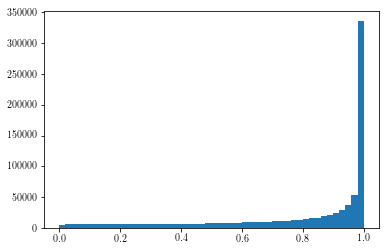

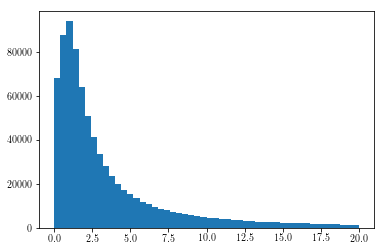

In [30]:
#investigate discrepancy by diong some histograms. 

plt.figure()
plt.hist(scatter_cat['purity'],bins=50)
plt.figure()
plt.hist(scatter_cat['snr_grpf'],bins=50,range=(0,20))

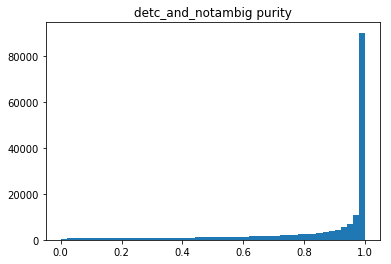

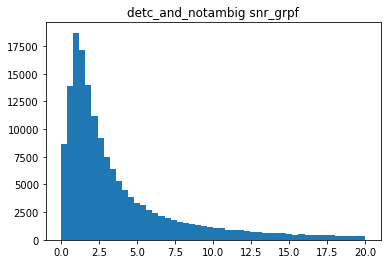

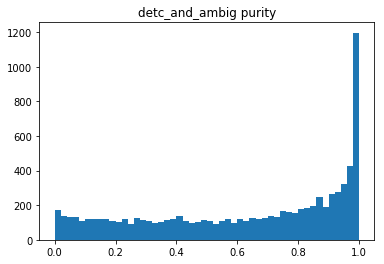

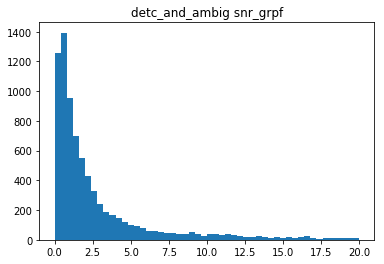

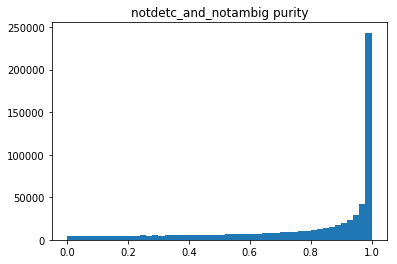

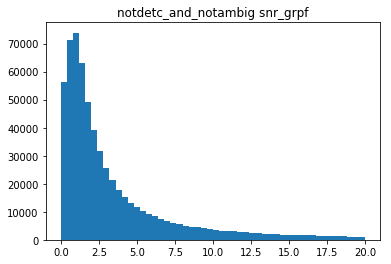

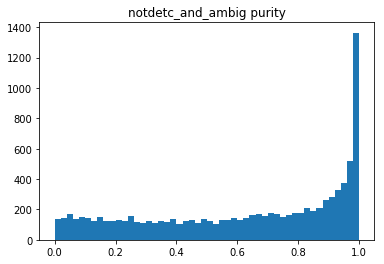

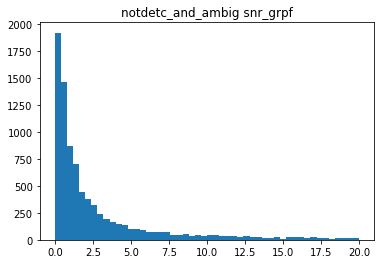

In [45]:
#what about in each region: 
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
analyze_cats=[detc_and_notambig(scatter_cat),detc_and_ambig(scatter_cat),notdetc_and_notambig(scatter_cat),notdetc_and_ambig(scatter_cat)]
for cat,name in zip(analyze_cats,names): 
    #histogram of one of the chips 
    plt.figure()
    plt.title(name + ' purity')
    plt.hist(cat['purity'],bins=50)
    plt.figure()
    plt.title(name + ' snr_grpf')
    plt.hist(cat['snr_grpf'],bins=50,range=(0,20))



In [16]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=False)


def purity_snr_scatter_poster(analyze_cat,colors,power,full_cat,ax,name,save=None):
    #divide into 4 groups 

    high_pur_high_snr = up_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = down_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = up_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = down_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(analyze_cat)
    p2 = float(len(high_pur_low_snr))/len(analyze_cat)
    p3 = float(len(low_pur_high_snr))/len(analyze_cat)
    p4 = float(len(low_pur_low_snr))/len(analyze_cat)

    #plot each group separately with different colors 
    plt.scatter(high_pur_high_snr['snr_grpf'],high_pur_high_snr['purity']**(power),alpha=.2,color=colors[0])
    plt.scatter(high_pur_low_snr['snr_grpf'],high_pur_low_snr['purity']**(power),alpha=.2,color=colors[1])
    plt.scatter(low_pur_high_snr['snr_grpf'],low_pur_high_snr['purity']**(power),alpha=.2,color=colors[2])
    plt.scatter(low_pur_low_snr['snr_grpf'],low_pur_low_snr['purity']**(power),alpha=.2,color=colors[3])

    
    #annotate with colors the percentages
    plt.annotate("High purity \& high snr: {0:.2g}\%".format(p1*100), xy=(0.60, 0.17), xycoords='axes fraction',color=colors[0],fontsize=14)
    plt.annotate("High purity \& low snr: {0:.2g}\%".format(p2*100), xy=(0.60, 0.13), xycoords='axes fraction',color=colors[1],fontsize=14)
    plt.annotate("Low purity \& high snr: {0:.2g}\%".format(p3*100), xy=(0.60, 0.09), xycoords='axes fraction',color=colors[2],fontsize=14)
    plt.annotate("Low purity \& Low snr: {0:.2g}\%".format(p4*100), xy=(0.60, 0.05), xycoords='axes fraction',color=colors[3],fontsize=14)
    plt.text(.60,.01,'Fraction of full catalogue: {0:.2g}\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=14)
    
#     plt.annotate("Fraction of full catalogue: {0:.1f}\%".format(float(len((cat)))/len(full_cat)*100), xy=(0.370, 0.07), xycoords='axes fraction',color=colors[4],fontsize=25)

    plt.xlabel(r'$\nu_{\rm grp}$',fontsize=40)
    plt.ylabel(r'$\rho^{12}$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
    plt.xlim(0,30)
    plt.ylim(0.,1.)
    plt.title(r'{}'.format(name))
    print 'the sum of the numerators for this square: {}'.format(len(high_pur_high_snr)+len(high_pur_low_snr) + len(low_pur_high_snr)+ len(low_pur_low_snr))



 

In [17]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


def purity_snr_scatter_final(fraction,analyze_cat,colors,power,full_cat,ax,name,save=None):
    #divide into 4 groups 

    high_pur_high_snr = up_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    high_pur_low_snr = down_cut(up_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    low_pur_high_snr = up_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    low_pur_low_snr = down_cut(down_cut(analyze_cat,'purity',.98),'snr_grpf',5)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(analyze_cat)
    p2 = float(len(high_pur_low_snr))/len(analyze_cat)
    p3 = float(len(low_pur_high_snr))/len(analyze_cat)
    p4 = float(len(low_pur_low_snr))/len(analyze_cat)
    
    #create smaller catalogues to plot them and reduce the density of points in each region. 
    small_hphs = small(high_pur_high_snr,int(len(high_pur_high_snr)* fraction))
    small_hpls = small(high_pur_low_snr,int(len(high_pur_low_snr)* fraction))
    small_lphs = small(low_pur_high_snr,int(len(low_pur_high_snr) * fraction))
    small_lpls = small(low_pur_low_snr,int(len(low_pur_low_snr)* fraction))

    orig_ticks = np.array([0.,0.142,0.5402,.785,1])
    new_ticks = []
    for label in orig_ticks: 
        new_ticks.append('{:.2g}'.format(label**(1./12)))
    
    #plot each group separately with different colors 
    plt.scatter(small_hphs['snr_grpf'],small_hphs['purity']**(power),alpha=.2,color=colors[0])
    
    #replace original ticks with of new ones. Do that for all. 
    plt.yticks(orig_ticks, new_ticks)
    
    plt.scatter(small_hpls['snr_grpf'],small_hpls['purity']**(power),alpha=.2,color=colors[1])
    plt.yticks(orig_ticks, new_ticks)

    plt.scatter(small_lphs['snr_grpf'],small_lphs['purity']**(power),alpha=.2,color=colors[2])
    plt.yticks(orig_ticks, new_ticks)
    
    plt.scatter(small_lpls['snr_grpf'],small_lpls['purity']**(power),alpha=.2,color=colors[3])
    plt.yticks(orig_ticks, new_ticks)


    #annotate with colors the percentages
    plt.annotate("{0:.1f}\%".format(p1*100), xy=(0.55, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p2*100), xy=(0.05, 0.885), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p3*100), xy=(0.05, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.annotate("{0:.1f}\%".format(p4*100), xy=(0.55, 0.4), xycoords='axes fraction',color='black',fontsize=30)
    plt.text(.380,.01,'Fraction of full catalogue:{0:.1f}\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=25)
    
    

    plt.xlabel(r'$\nu_{\rm grpf}$',fontsize=40)
    plt.ylabel(r'$\rho$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
    plt.xlim(0,30)
    plt.ylim(0.,1.)
    #plt.title(name)



 

In [18]:
scatter_cat = deepcopy(main_catsLSST[4])

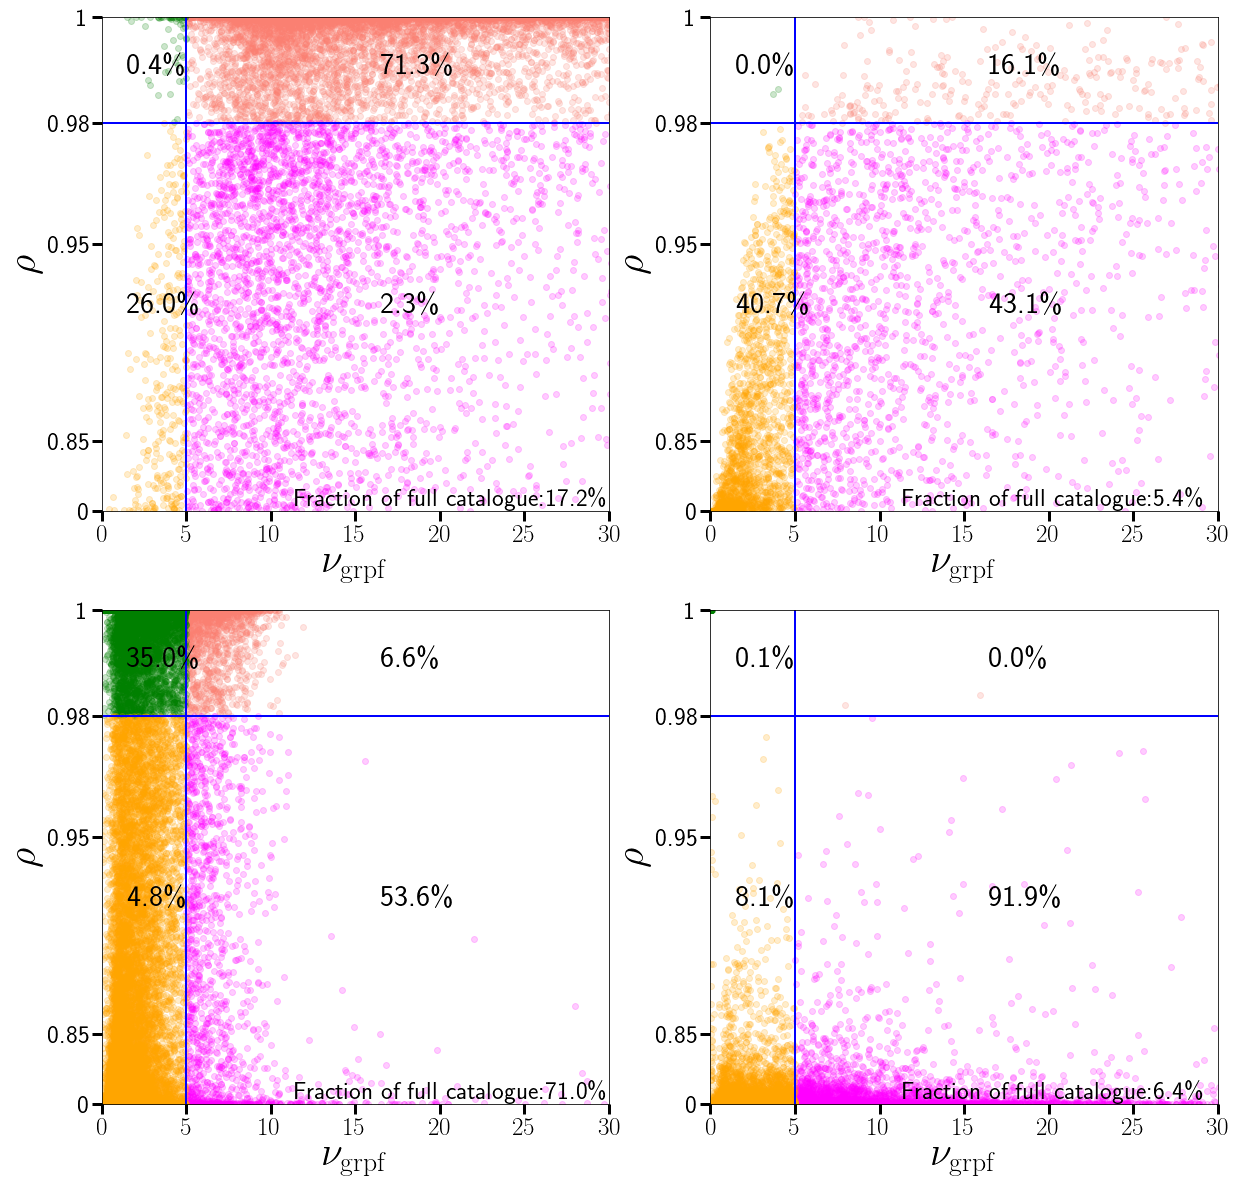

In [19]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 2,2
power = 12. 

cats =[detc_and_notambig(scatter_cat),detc_and_ambig(scatter_cat),notdetc_and_notambig(scatter_cat),notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['salmon', 'green', 'magenta', 'orange','black']
fractions = [1./10,1./10, 1./20, 1.]

for i,(name,temp_cat,fraction) in enumerate(zip(names,cats,fractions)):
    ax = plt.subplot(nrow, ncol, i+1)
    plt.axhline(.98**power,color='blue',linewidth=2)
    plt.axvline(5,color='blue',linewidth=2)
    purity_snr_scatter_final(fraction, temp_cat,colors,power,scatter_cat,ax,name)
    #as reference for debugging, 

plt.xlim(0,30)
fig.savefig('/Users/Ismael/Desktop/scatter_1.pdf')

In [101]:
temp = detc_and_notambig(scatter_cat)
temp2 = up_cut(up_cut(temp,'purity',.98),'snr_grpf',6)

print 'percentage in plot should be:{}'.format(float(len(temp2))/ len(temp )) 

print 'this catalogue includes objects above snr_grpf of 30: {}'.format(len(temp2[temp2['snr_grpf']>30])) 

percentage in plot should be:0.706653782441
this catalogue includes objects above snr_grpf of 30: 34549


In [81]:
len(main_catsLSST[4])

844643

In [144]:
import matplotlib.pyplot as plt, numpy as np, numpy.random, scipy

#histogram definition
xyrange = [[-5,5],[-5,5]] # data range
bins = [100,100] # number of bins
thresh = 3  #density threshold

#data definition
N = 1e5;
xdat, ydat = np.random.normal(size=N), np.random.normal(1, 0.6, size=N)

# histogram the data
hh, locx, locy = scipy.histogram2d(xdat, ydat, range=xyrange, bins=bins)
posx = np.digitize(xdat, locx)
posy = np.digitize(ydat, locy)

#select points within the histogram
ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
xdat1 = xdat[ind][hhsub < thresh] # low density points
ydat1 = ydat[ind][hhsub < thresh]
hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')
plt.colorbar()   
plt.plot(xdat1, ydat1, '.',color='darkblue')
plt.show()

TypeError: 'float' object cannot be interpreted as an index

In [142]:
def purity_snr_density(analyze_cat,colors,power,full_cat,ax,name,save=None):

    #histogram definition
    xyrange = [[0,30],[0,1]] # data range
    
    #do a hist2d of the data 
    xdat, ydat = analyze_cat['snr_grpf'], analyze_cat['purity']**(power)
    ax.hist2d(xdat, ydat, bins=(30,20), range=xyrange, cmap=plt.cm.jet,cmin=0,cmax=5000)

    
    plt.xlabel(r'$\nu_{\rm grp}$',fontsize=40)
    plt.ylabel(r'$\rho^{12}$',fontsize=40)
    plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
    plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)



RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

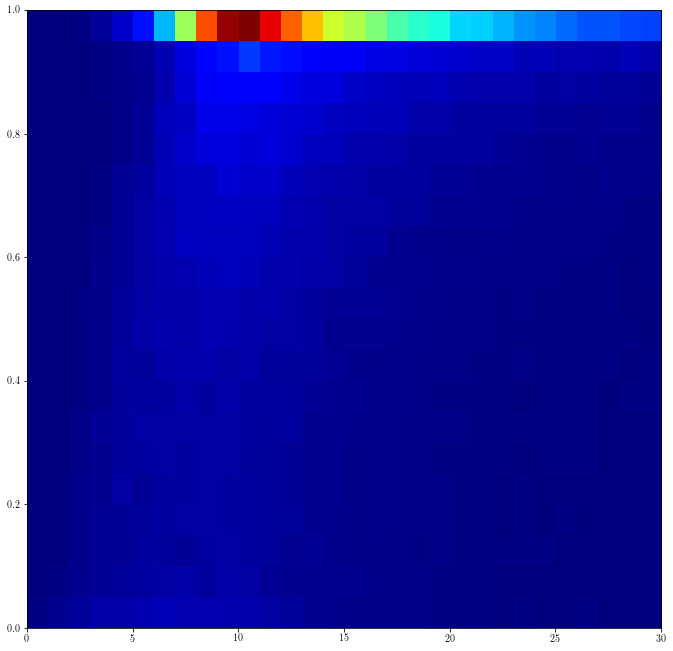

In [143]:
import scipy 
fig = plt.figure(figsize=(25,25))
nrow,ncol = 2,2
power = 12. 

cats =[detc_and_notambig(scatter_cat),detc_and_ambig(scatter_cat),notdetc_and_notambig(scatter_cat),notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['Reds', 'Greens', 'Blues', 'Purples','Greys']

for i,(name,temp_cat) in enumerate(zip(names,cats)):
    ax = fig.add_subplot(nrow, ncol, i+1)
    purity_snr_density(temp_cat,colors,power,scatter_cat,ax,name)
    ax.axhline(.98**power,color='cyan',linewidth=2)
    ax.axvline(6,color='cyan',linewidth=2)

plt.show()
#fig.savefig('/Users/Ismael/Desktop/scatter_1.pdf')

In [106]:
def purity_snr_density2(analyze_cat,colors,power,full_cat,ax1,ax2,name,save=None):

    
    #histogram definition
    xyrange = [[0,30],[0,1]] # data range
    
    #get tick marks for purity 
    xdat, ydat = analyze_cat['snr_grpf'], analyze_cat['purity']
    ax2.hist2d(xdat, ydat, bins=(100,10), range=xyrange, cmap=plt.cm.jet)
    
    #get_xticks
    xdat, ydat = analyze_cat['snr_grpf'], analyze_cat['purity']
    ax2.hist2d(xdat, ydat, bins=(100,10), range=xyrange, cmap=plt.cm.jet)
    
    ax.axhline(.98**power,color='green',linewidth=2)
    paxlt.axvline(6,color='green',linewidth=2)
    
    #do a hist2d of the data 
    xdat, ydat = analyze_cat['snr_grpf'], analyze_cat['purity']**(power)
    ax1.hist2d(xdat, ydat, bins=(100,10), range=xyrange, cmap=plt.cm.jet)
    
    ax.axhline(.98**power,color='green',linewidth=2)
    paxlt.axvline(6,color='green',linewidth=2)

    
#     # histogram the data
#     hh, locx, locy = np.histogram2d(xdat, ydat, range=xyrange, bins=bins)
#     posx = np.digitize(xdat, locx)
#     posy = np.digitize(ydat, locy)

#     #select points within the histogram
#     ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
#     hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
#     xdat1 = xdat[ind][hhsub < thresh] # low density points
#     ydat1 = ydat[ind][hhsub < thresh]
#     hh[hh < thresh] = np.nan # fill the areas with low density by NaNs

#     plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper')
#     plt.colorbar()   
#     plt.plot(xdat1, ydat1, '.',color='darkblue')
#     plt.show()

#     #plot each group separately with different colors 
#     sns.kdeplot(high_pur_high_snr['snr_grpf'],high_pur_high_snr['purity']**(power),alpha=.2,cmap=colors[0])
#     sns.kdeplot(high_pur_low_snr['snr_grpf'],high_pur_low_snr['purity']**(power),alpha=.2,cmap=colors[1])
#     sns.kdeplot(low_pur_high_snr['snr_grpf'],low_pur_high_snr['purity']**(power),alpha=.2,cmap=colors[2])
#     sns.kdeplot(low_pur_low_snr['snr_grpf'],low_pur_low_snr['purity']**(power),alpha=.2,cmap=colors[3])


#     #annotate with colors the percentages
#     plt.annotate("High purity \& high snr: {0:.2g}\%".format(p1*100), xy=(0.60, 0.17), xycoords='axes fraction',color=colors[0],fontsize=14)
#     plt.annotate("High purity \& low snr: {0:.2g}\%".format(p2*100), xy=(0.60, 0.13), xycoords='axes fraction',color=colors[1],fontsize=14)
#     plt.annotate("Low purity \& high snr: {0:.2g}\%".format(p3*100), xy=(0.60, 0.09), xycoords='axes fraction',color=colors[2],fontsize=14)
#     plt.annotate("Low purity \& Low snr: {0:.2g}\%".format(p4*100), xy=(0.60, 0.05), xycoords='axes fraction',color=colors[3],fontsize=14)
#     plt.text(.60,.01,'Fraction of full catalogue: {0:.2g}\%'.format(float(len((analyze_cat)))/len(full_cat)*100),transform=ax.transAxes,fontsize=14)

    #     plt.annotate("Fraction of full catalogue: {0:.1f}\%".format(float(len((cat)))/len(full_cat)*100), xy=(0.370, 0.07), xycoords='axes fraction',color=colors[4],fontsize=25)

    
    
    
#     plt.xlabel(r'$\nu_{\rm grp}$',fontsize=40)
#     plt.ylabel(r'$\rho^{12}$',fontsize=40)
#     plt.tick_params(axis='x', which='major',labelsize=25,size=10,width=3)
#     plt.tick_params(axis='y', which='major',labelsize=25,size=10,width=3)
#     plt.xlim(0,30)
#     plt.ylim(0.,1.)
#     plt.title(r'{}'.format(name))
#     print 'the sum of the numerators for this square: {}'.format(len(high_pur_high_snr)+len(high_pur_low_snr) + len(low_pur_high_snr)+ len(low_pur_low_snr))




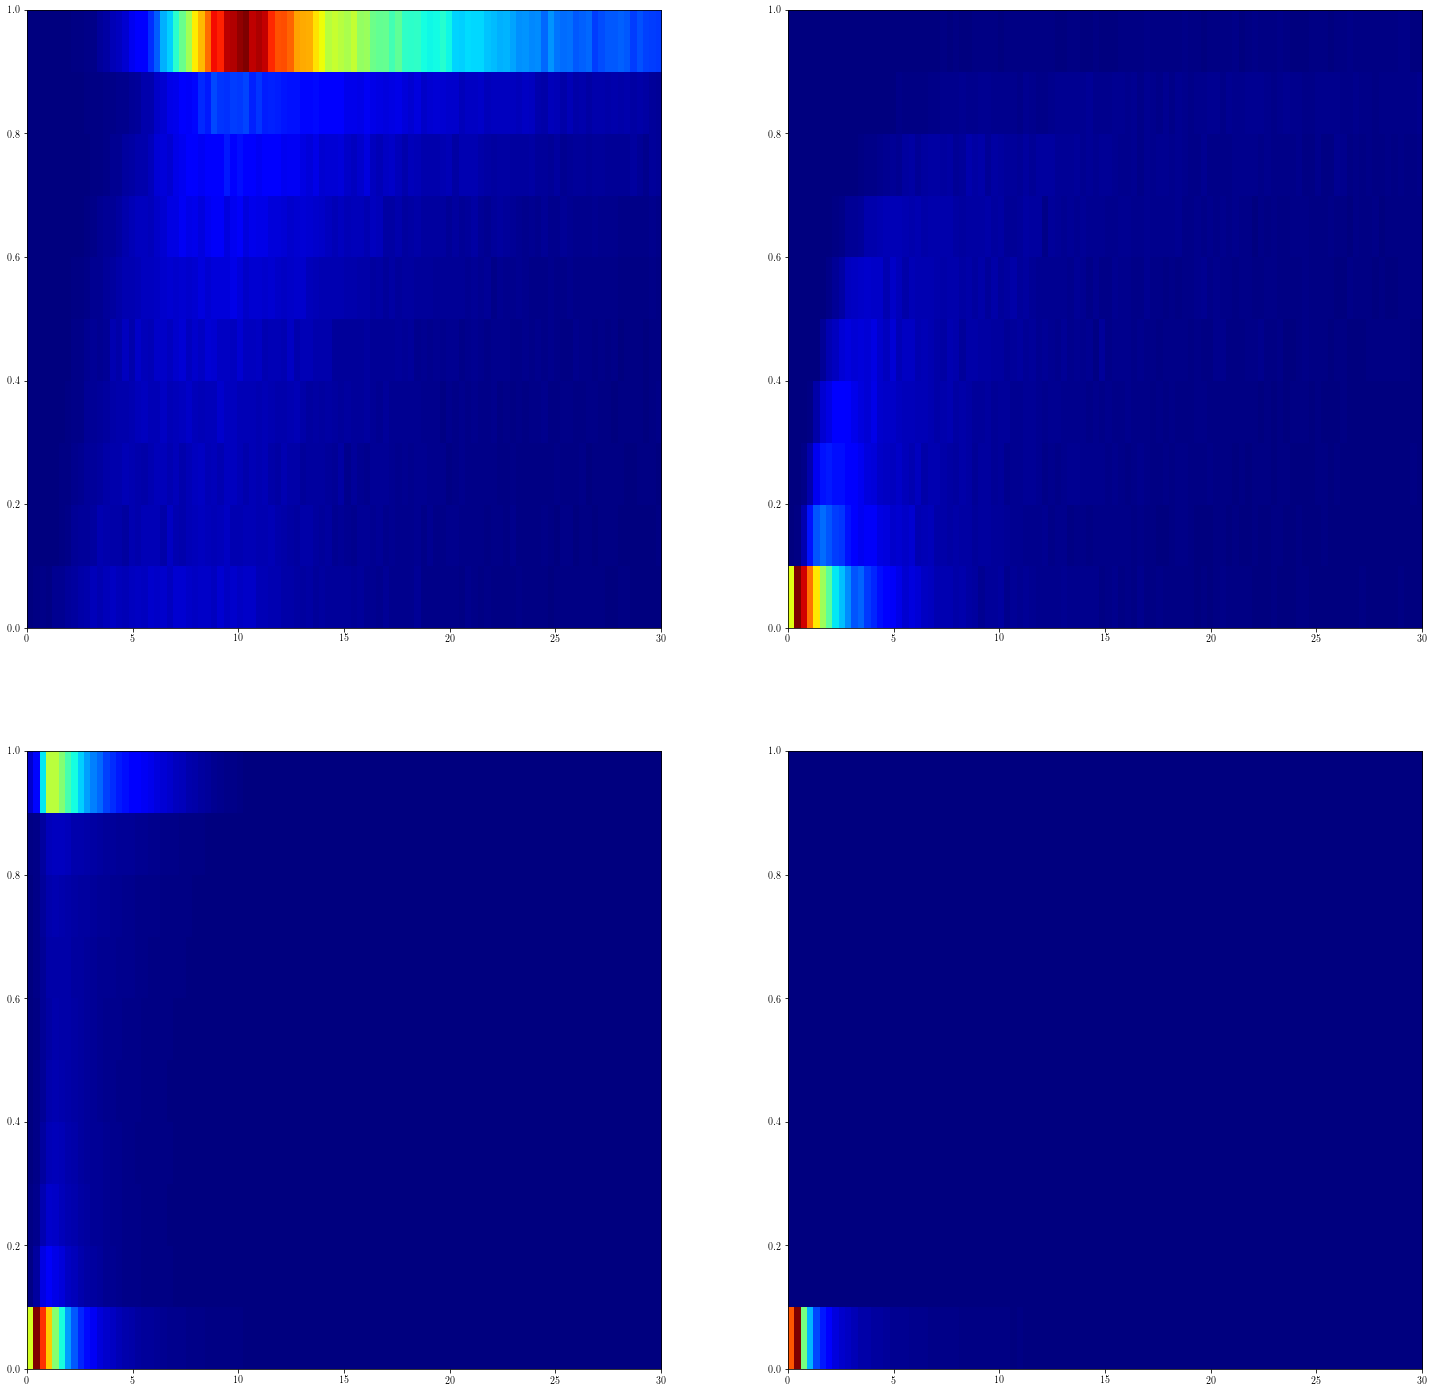

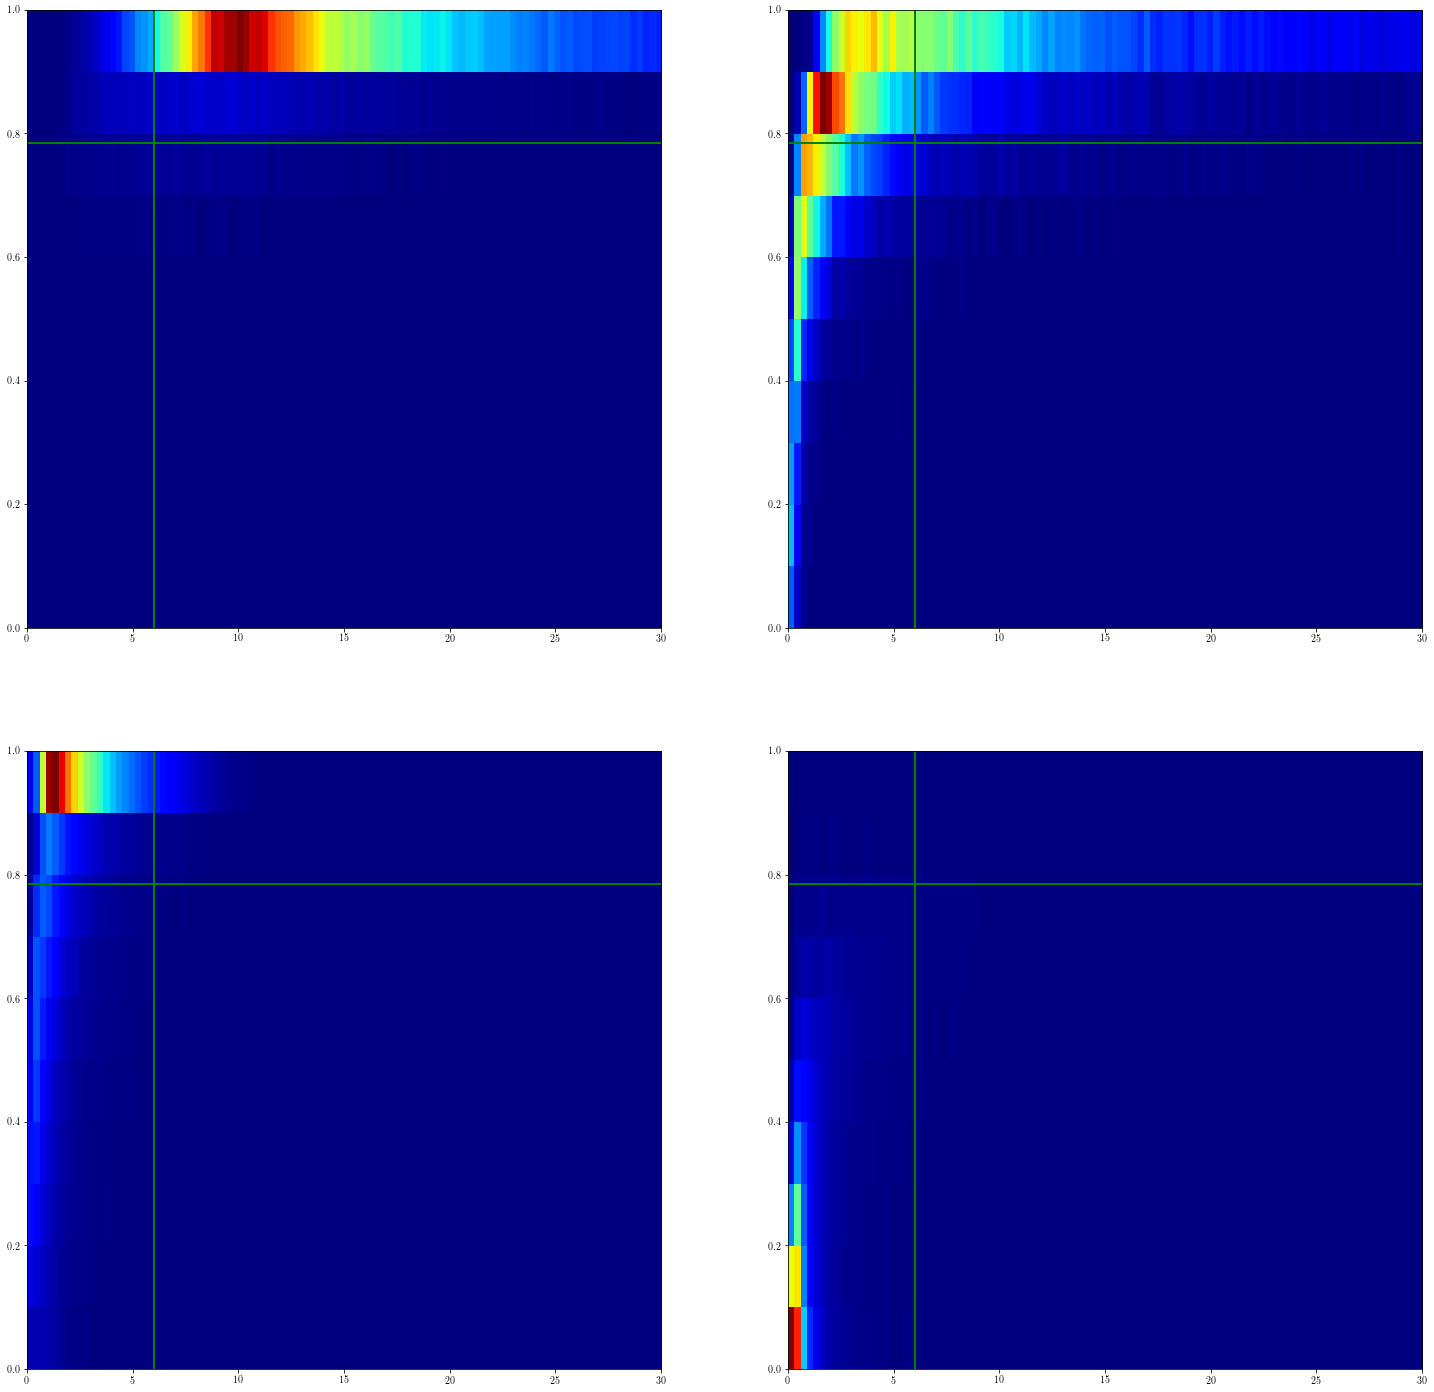

In [107]:
import scipy 
fig1 = plt.figure(figsize=(25,25))
fig2 = plt.figure(figsize=(25,25))
nrow,ncol = 2,2
power = 12. 

cats =[detc_and_notambig(scatter_cat),detc_and_ambig(scatter_cat),notdetc_and_notambig(scatter_cat),notdetc_and_ambig(scatter_cat)]
names = ['detc_and_notambig','detc_and_ambig','notdetc_and_notambig','notdetc_and_ambig']
colors= ['Reds', 'Greens', 'Blues', 'Purples','Greys']

for i,(name,temp_cat) in enumerate(zip(names,cats)):
    ax1 = fig1.add_subplot(nrow, ncol, i+1)
    ax2 = fig2.add_subplot(nrow, ncol, i+1)

    purity_snr_density(temp_cat,colors,power,scatter_cat,ax1,ax2,name)
    #as reference for debugging, 
#     print 'this is the size of the catalogue for that square: {}'.format(len(temp_cat))
#     print 'this is the size of the catalogue for the whole thing: {}'.format(len(scatter_cat))
# print 'the sum of the numerators for the whole thing: {}'.format(sum([len(tcat) for tcat in cats]))

plt.show()
#fig.savefig('/Users/Ismael/Desktop/scatter_1.pdf')

## Money plot using bootstrap variance. 

In [76]:
len(good(best(main_catsLSST[4])))

103006

In [77]:
intersection = set() 
for i,cat in enumerate(main_catsLSST): 
    if i==0: 
        intersection = set(cat['db_id']) 
    print 'intersection {}'.format(len(intersection))
    print 'curr catalogue {}'.format(len(cat))
    intersection = intersection.intersection(cat['db_id'])
#does not change that much. 

intersection 844272
curr catalogue 844272
intersection 844272
curr catalogue 844660
intersection 843818
curr catalogue 844465
intersection 843498
curr catalogue 844290
intersection 843355
curr catalogue 844643
intersection 843192
curr catalogue 844705
intersection 843150
curr catalogue 844212
intersection 843071
curr catalogue 844384
intersection 843040
curr catalogue 844742


In [79]:
intersection = set() 
for i,cat in enumerate(get_filter_cats(main_catsDES,[good,best])): 
    if i==0: 
        intersection = set(cat['db_id']) 
    print 'intersection {}'.format(len(intersection))
    print 'curr catalogue {}'.format(len(cat))
    intersection = intersection.intersection(cat['db_id'])
#does not change that much. 

intersection 15671
curr catalogue 15671
intersection 15671
curr catalogue 15801
intersection 13461
curr catalogue 15866
intersection 12517
curr catalogue 15839
intersection 12006
curr catalogue 15714
intersection 11630
curr catalogue 15768
intersection 11309
curr catalogue 15842
intersection 11099
curr catalogue 15826
intersection 10907
curr catalogue 15735


In [64]:
for gal_id in 
intersection

{402700320819,
 402716098565,
 2212495366,
 2208301068,
 402716098579,
 402703515668,
 402701418518,
 402707709976,
 402714001435,
 2206553434,
 402716098591,
 2216689696,
 402701418531,
 402715788272,
 402714001451,
 402705612844,
 402714001453,
 2216689712,
 402714001458,
 2212495413,
 2209349641,
 2217388724,
 402711904314,
 402709807164,
 402711904318,
 2214592578,
 402716098627,
 2211100898,
 2200597769,
 2202009682,
 402703515733,
 2210398294,
 402709457594,
 402716098654,
 2202009699,
 2204106853,
 402716098662,
 2211097276,
 2214592619,
 2214592623,
 402710156648,
 2214592629,
 2216340159,
 2202009726,
 402716961448,
 2208650603,
 2204106884,
 2208301078,
 2209000129,
 2216689806,
 402711904404,
 402703515802,
 402707710110,
 2210398367,
 402701418659,
 2202009765,
 2216689830,
 402705612967,
 402703515816,
 2209441187,
 402711904427,
 402701418669,
 402711904430,
 402707710134,
 2210398391,
 402711904444,
 402709807294,
 402705612993,
 2206204098,
 2208301251,
 2204106950,
 22

In [34]:
t=main_catsLSST[4]

In [29]:
intersection_matrix = np.zeros((len(main_catsLSST), len(main_catsLSST)))
for i in range(len(main_catsLSST)): 
    for j in range(len(main_catsLSST)): 
        cat_i = main_catsLSST[i]
        cat_j = main_catsLSST[j]
        filter_cats = get_filter_cats([cat_i, cat_j],[gold,best])
        intersection_cats = get_intersection_cats(filter_cats)
        length_intersection = float(len(intersection_cats[0]))
        intersection_matrix[i,j] = length_intersection/ max([len(cat) for cat in filter_cats])
        
        

In [33]:
filter_cats = get_filter_cats([main_catsLSST[0], main_catsLSST[-1]],[gold,best])
intersection_cats = get_intersection_cats(filter_cats)
print len(intersection_cats[0]), len(intersection_cats[1]), len(filter_cats[0]), len(filter_cats[1])
print float(len(intersection_cats[0]))/ max([len(cat) for cat in filter_cats])

117523 117523 123195 123047
0.953959170421


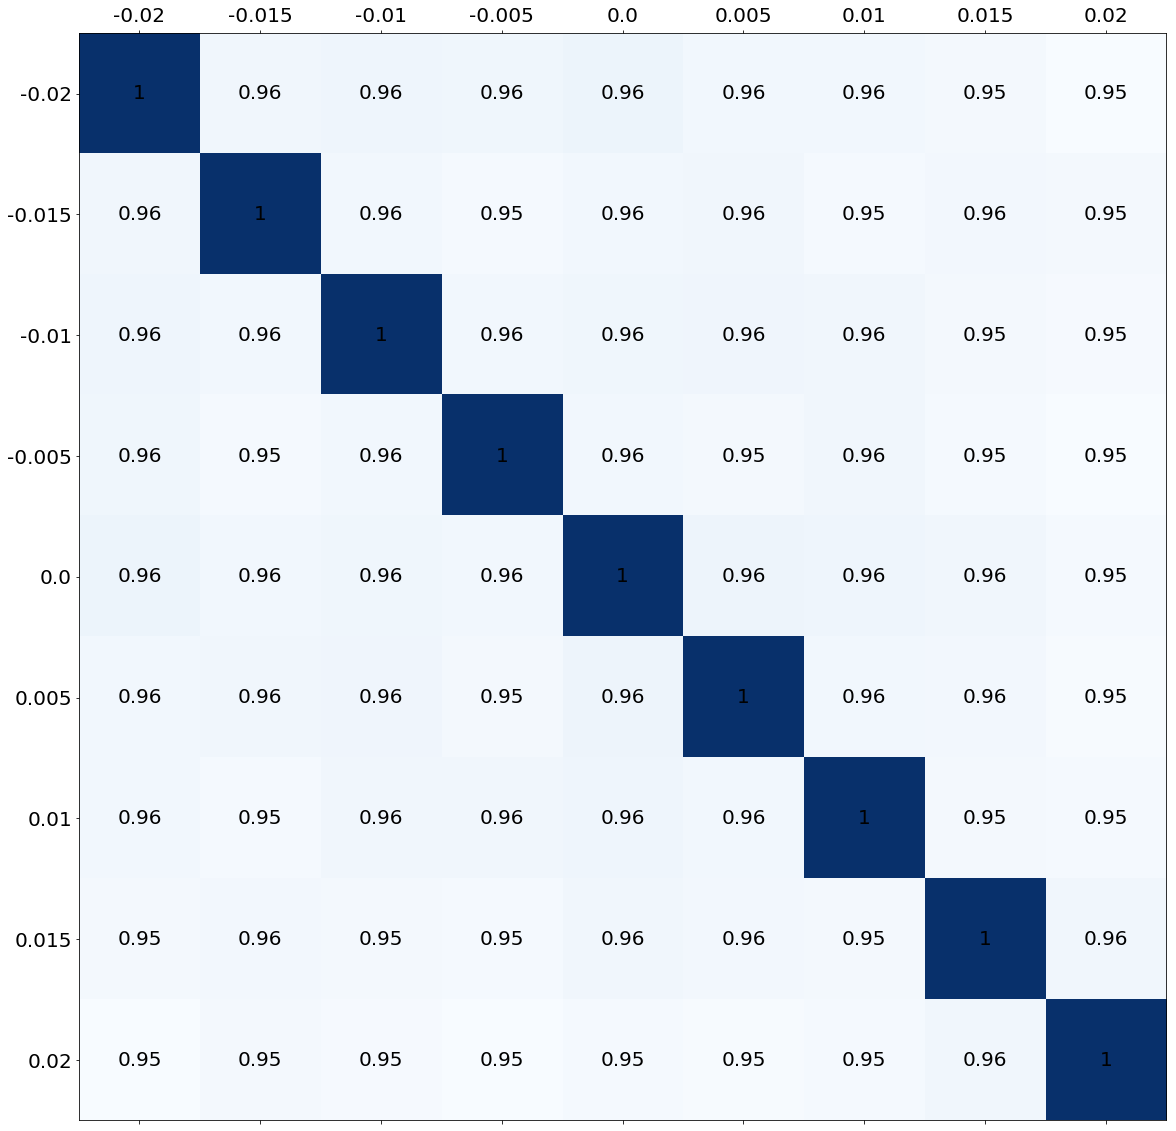

In [31]:
plot_matrix(intersection_matrix,g1s)

In [66]:
result_cats = get_intersection_cats(main_catsLSST[:2])

1
2
3
843818
2
3
843818
[<Table length=843818>
   db_id        grp_id    grp_size grp_rank ...  bias_y_grp  match ambig_blend
   int64        int64      int16    int16   ...   float32    int64     bool   
------------ ------------ -------- -------- ... ------------ ----- -----------
402713998325 402713998325        1        0 ...   0.00138752    -1       False
402707721988 402707721988        1        0 ... -0.000392486    -1       False
402711568059 402711568059        2        0 ...   0.00127277    -1       False
402715332898 402711568059        2        1 ...    0.0107497    -1       False
402709443937 402709443937        2        0 ...  0.000675143    -1       False
402714392263 402709443937        2        1 ...  -0.00520992    -1       False
402701771027 402701771027        1        0 ...  8.20965e-08  1772       False
402701802864 402701802864        2        0 ... -0.000608175  1785       False
402713992486 402713992486        1        0 ...  0.000271374    -1       False
40271

In [61]:
type(result_cats)

list

In [68]:
for res in result_cats: 
    print len(res)
set(result_cats[0]['db_id']) == set(result_cats[1]['db_id'])

843818
843818


True

In [93]:
#what do the objects that do not intersect look like? 
filtered_cats = get_filter_cats(main_catsLSST,[good,best])
intersect_cats,non_intersect_cats = get_intersection_cats(filtered_cats,other_cats=True)

In [96]:
print [len(cat) for cat in intersect_cats]
print [len(cat) for cat in filtered_cats]
print [len(cat) for cat in non_intersect_cats]

[85151, 85151, 85151, 85151, 85151, 85151, 85151, 85151, 85151]
[103130, 102986, 103139, 103079, 103006, 102991, 103104, 102944, 102950]
[17979, 17835, 17988, 17928, 17855, 17840, 17953, 17793, 17799]


In [104]:
def plot_histogram(cat,title=None): 
    g_min,g_max = -2,2
    plt.hist(cat['bias_g1_grp'],histtype='step',bins=100,range=[g_min,g_max],color='red',label='blending on')
    plt.hist(cat['bias_g1'],histtype='step',bins=100,range=[g_min,g_max],color='green',label='blending off')
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlim(g_min,g_max)
    plt.yscale('log')
    plt.legend(prop={'size':15})
    if title!= None: 
        plt.title(title,size=20)

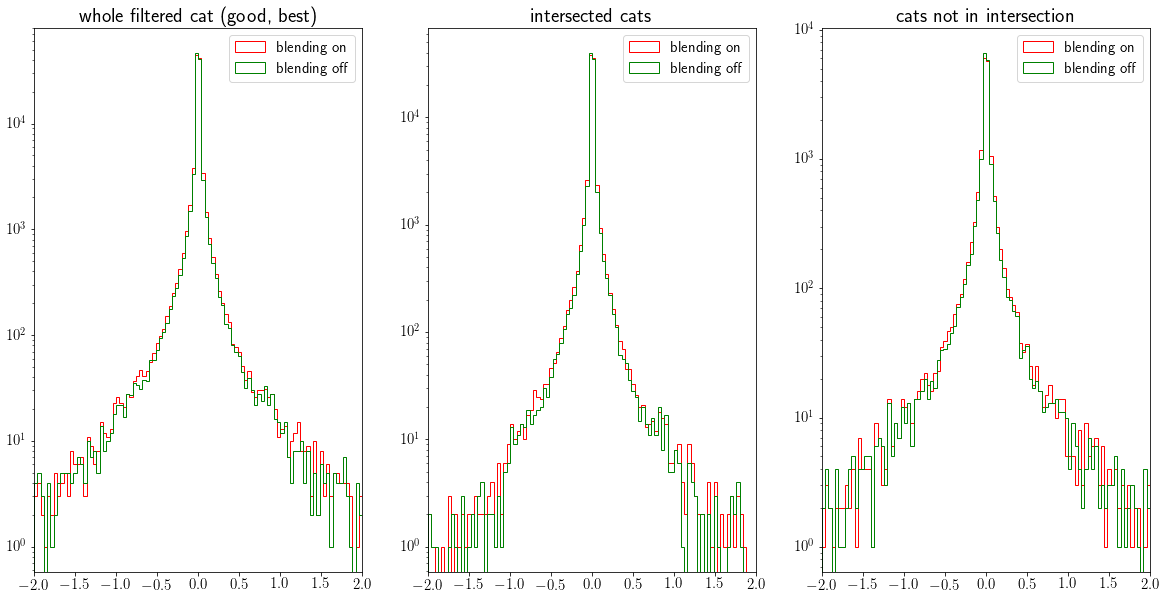

In [105]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(131) 
plot_histogram(filtered_cats[0],title='whole filtered cat (good, best)')
fig.add_subplot(132) 
plot_histogram(intersect_cats[0],title='intersected cats')
fig.add_subplot(133) 
plot_histogram(non_intersect_cats[0],title='cats not in intersection')

# Calculate a quasi-covariance matrix for each set of 9 catalogs 

In [90]:
def get_covariance_matrices(main_cats, filters): 
    num_cats = len(main_cats)
    covariance_matrix = np.zeros((num_cats, num_cats))
    covariance_matrix_grp = np.zeros((num_cats,num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            cat_i = main_catsLSST[i]
            cat_j = main_catsLSST[j]
            filter_cats = get_filter_cats([cat_i, cat_j],filters)
            intersection_cats = get_intersection_cats(filter_cats)
            intersect_cat1 = intersection_cats[0]
            intersect_cat2 = intersection_cats[1]
            length_intersection = float(len(intersection_cats[0]))
            b1_med_grp,b2_med_grp = np.median(intersect_cat1['bias_g1_grp']),np.median(intersect_cat2['bias_g1_grp'])
            b1_med,b2_med = np.median(intersect_cat1['bias_g1']),np.median(intersect_cat2['bias_g1'])
            covariance_matrix_grp[i,j] = np.sum((intersect_cat1['bias_g1_grp'] - b1_med_grp)*(intersect_cat1['bias_g2_grp'] - b2_med_grp))/(length_intersection-1)
            covariance_matrix[i,j] = np.sum((intersect_cat1['bias_g1'] - b1_med)*(intersect_cat1['bias_g2'] - b2_med))/(length_intersection-1)
            
    #also calculate correlation matrices just for fun. 
    correlation_matrix = np.zeros((num_cats, num_cats))
    correlation_matrix_grp = np.zeros((num_cats,num_cats))
    for i in range(num_cats): 
        for j in range(num_cats)[:i+1]: 
            correlation_matrix[i,j] = covariance_matrix[i,j]/ np.sqrt(covariance_matrix[i,i]*covariance_matrix[j,j])
            correlation_matrix_grp[i,j] = covariance_matrix_grp[i,j]/ np.sqrt(covariance_matrix_grp[i,i]*covariance_matrix_grp[j,j])


    
    return covariance_matrix, covariance_matrix_grp,correlation_matrix,correlation_matrix_grp

## LSST 

### gold 

In [20]:
#use boostrap to calculate error on the median. 
def sigma_mean_boot(cats,param,filters):
    stds = []
    true_mean = np.mean(cats[param])
    filter_cats = get_filter_cats(cats,filters)
    for cat in filter_cats: 
        n = len(cat)
    
        #generate random N sample with replacement 
        N = 10000
        means = []
        for i in range(N):
            sample = np.random.choice(cat[param],size=n)
            means.append(np.mean(sample))
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print 'just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(means,[16,84]) - true_mean))
        stds.append(np.percentile(means,84))
    return stds


def sigma_med_boot(cats,param,filters):
    stds = []
    true_median = np.median(cats[param])
    filter_cats = get_filter_cats(cats,filters)
    for cat in filter_cats: 
        n = len(cat)
    
        #generate random N sample with replacement 
        N = 10000
        meds = []
        for i in range(N):
            sample = np.random.choice(cat[param],size=n)
            meds.append(np.median(sample))
            
        #stds.append((n,np.std(meds),meds)) #make it a 68% percentile instead of std, more robust. 
        print 'just to check that symmetry is respected print both percentiles: {}'.format(np.absolute(np.percentile(meds,[16,84]) - true_median))
        stds.append(np.percentile(meds,84))
    return stds
    

In [50]:
#calculate error on the slope for a linear function that goes through the origin with bootstrap. 
def err_slope_boot(cats,param,filters): 
    meds = [] #each of this is a tuple of 9 medians to fit
    
    filter_cats = get_filter_cats(main_cats,filters)        
    intersect_cats = get_intersection_cats(filter_cats)
    

        
    #generate random N samples of the slope. 
    N = 10000
    slopes = []
        
        
        
    

IndentationError: unexpected indent (<ipython-input-50-fb9c199cd0f6>, line 18)

In [66]:
def get_money_plot(gi,stds_grp,stds_iso,filters,main_cats,ticks1=None,ticks2=None,ticks3=None,labely1=None):
    def f(B, x):
        '''Linear function y = m*x that passes thorugh origin.'''
        # B is the slope of the line that passes through the origin.
        # x is an array of the current x values.
        # x is in the same format as the x passed to Data or RealData.
        #
        # Return an array in the same format as y passed to Data or RealData.
        return B[0]*x + B[1]

    import scipy.odr
    plt.rc('text', usetex=True)

    figure1 = plt.figure(figsize=(20, 20))
    figure2 = plt.figure(figsize=(10, 10))
    
    temp_cats = get_filter_cats(main_cats,filters)

    ####BLENDED        
    means = [np.mean(temp_cat['bias_{}_grp'.format(gi)]) for temp_cat in temp_cats]
    medians = [np.median(temp_cat['bias_{}_grp'.format(gi)]) for temp_cat in temp_cats]
    sigmas = [mad(temp_cat['bias_{}_grp'.format(gi)]) for temp_cat in temp_cats]
    # use the method describe in the page above for std of the median 
    errs = [np.abs(med - std) for (med,std) in zip(medians,stds_grp)]

    ax1 = figure1.add_subplot(111)
    ax2 = figure2.add_subplot(111)

    print 'means grp:' = means
    print 'medians grp:',medians
    print 'sigmas grp:',sigmas 
    print 'errs grp:',errs
    ax1.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='blue',capsize=3)

    linear = scipy.odr.Model(f)
    mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
    myodr = scipy.odr.ODR(mydata, linear, beta0=[1.,2.])
    myoutput = myodr.run()
    myoutput.pprint()

    #plot line, 
    beta0 = myoutput.beta[0]
    beta1 = myoutput.beta[1]
    x= g1s
    y = [beta0*g1 + beta1 for g1 in x]
    ax1.plot(x,y,c='b')


    ####second plot 
    plt.figure()
    x = g1s[4:]
    y = []
    yerrs= []
    for i,median in enumerate(medians[4:]): 
        y.append(medians[i] + medians[-(i+1)])
        yerrs.append(np.sqrt(errs[i]**2 + errs[-(i+1)]**2))


    ax2.errorbar(x,y,yerr=yerrs,marker='o',linestyle=' ',color='blue',capsize=3)

    ################UNBLENDED 

    means = [np.mean(temp_cat['bias_{}'.format(gi)]) for temp_cat in temp_cats]
    medians = [np.median(temp_cat['bias_{}'.format(gi)]) for temp_cat in temp_cats]
    sigmas = [mad(temp_cat['bias_{}'.format(gi)]) for temp_cat in temp_cats]
    # use the method describe in the page above for std of the median 
    errs = [np.abs(med - std) for (med,std) in zip(medians,stds_iso)]


    print 'means iso:' = means
    print 'medians iso:',medians
    print 'sigmas iso:',sigmas 
    print 'errs iso:',errs
    ax1.errorbar(g1s,medians,yerr=errs,marker='o',linestyle=' ',color='red',capsize=3)


    linear = scipy.odr.Model(f)
    mydata = scipy.odr.RealData(g1s, medians, sy=sigmas)
    myodr = scipy.odr.ODR(mydata, linear, beta0=[1.,2.])
    myoutput = myodr.run()
    myoutput.pprint()

    #plot line, 
    beta0 = myoutput.beta[0]
    beta1 = myoutput.beta[1]
    x = g1s
    y = [beta0*g1 + beta1 for g1 in x]
    ax1.plot(x,y,c='r')


    ####second plot 
    x = g1s[4:]
    y = []
    yerrs= []
    for i,median in enumerate(medians[4:]): 
        y.append(medians[i] + medians[-(i+1)])
        yerrs.append(np.sqrt(errs[i]**2 + errs[-(i+1)]**2))

    ax2.errorbar(x,y,yerr=yerrs,marker='o',linestyle=' ',color='red',capsize=3)



    ################formatting 
    
    #plt.ylim(-10,10)
    ax1.set_xlim([-.025,.025])


    ax1.tick_params(axis='both', which='major', labelsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)


    # ax1.yticks(size=20)
    num = gi[1:]

    ax1.set_xlabel(r'$g_{}$'.format(num),size=40)
    
    if labely1 != None: 
        ax1.set_ylabel(r'\rm {}'.format(labely1),size=40)

    ax2.set_xlabel(r'${}$'.format(gi),size=40)


    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    # ax.get_yaxis().get_offset_text().set_size(1)

    ax1.axhline(0,c='g')
    ax2.axhline(0,c='g')

    ax1.tick_params(axis='both', size=10,width=3,which='both')
    ax2.tick_params(axis='both', size=10,width=3,which='both')


    if ticks1 != None: 
        ax1.set_yticklabels(ticks1)
    
    
    if ticks2 != None: 
        ax2.set_yticklabels(ticks2)
        
    if ticks3 != None: 
        ax2.set_xticklabels(ticks3)


# LSST 

### Gold galaxies 

In [22]:
filters = [gold,best]

#### g1 

In [17]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgold_g1grp = sigma_med_boot(main_catsLSST,'bias_g1_grp',filters) 
stds_LSSTgold_g1iso = sigma_med_boot(main_catsLSST,'bias_g1', filters) 

medians grp: [-6.4274347e-05, -4.6882971e-05, -2.8643775e-05, -1.5612506e-05, -2.0888037e-06, 8.1217795e-06, 2.0092788e-05, 3.750695e-05, 5.6936067e-05]
sigmas grp: [0.0073884875, 0.0073501216, 0.0073839985, 0.0073391749, 0.0073685776, 0.0073742955, 0.0073544933, 0.0073503884, 0.0073657655]
errs grp: [6.0990828e-06, 5.4330217e-06, 4.6749183e-06, 4.3363812e-06, 3.2428584e-06, 3.4884156e-06, 4.2228057e-06, 5.1845032e-06, 6.0969483e-06]
Beta: [ 0.00286992]
Beta Std Error: [ 0.00013289]
Beta Covariance: [[ 0.04169044]]
Residual Variance: 4.23586802167e-07
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-2.9083674e-05, -1.9762476e-05, -9.7051043e-06, -3.8076228e-06, 4.9107252e-09, 3.9948891e-06, 1.0424065e-05, 1.8292252e-05, 2.8018076e-05]
sigmas iso: [0.0048915897, 0.0048768506, 0.0048600985, 0.0048146201, 0.0048160749, 0.0048346007, 0.0048322128, 0.004841561, 0.0048979856]
errs iso: [2.5077984e-06, 2.0926877e-06, 1.4808026e-06, 8.5450949e-07, 2.1

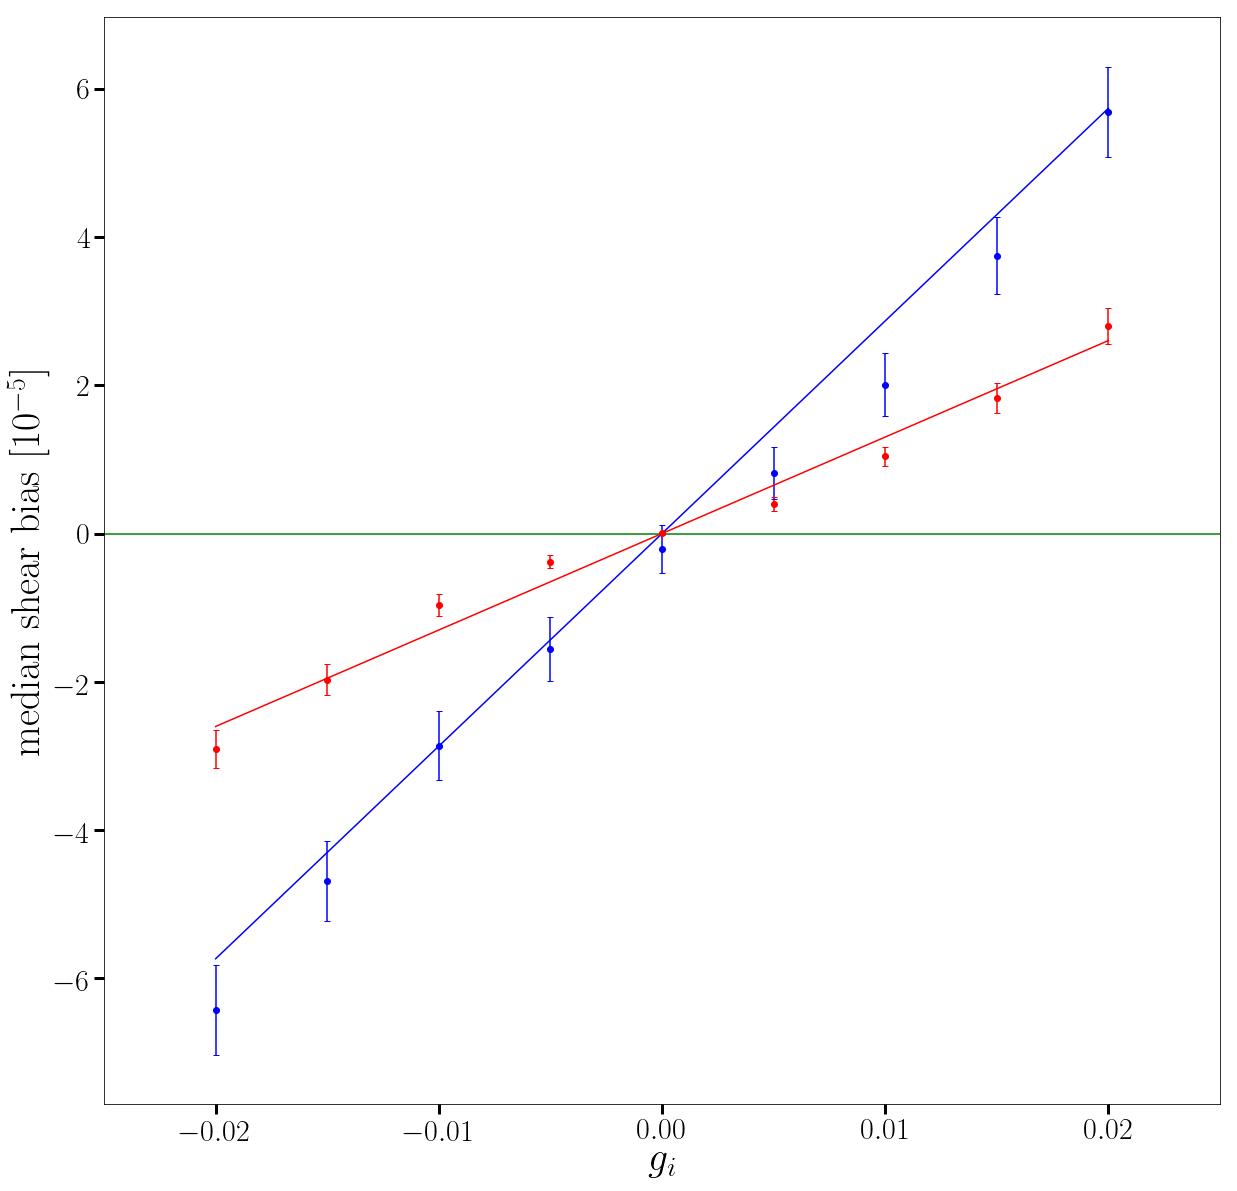

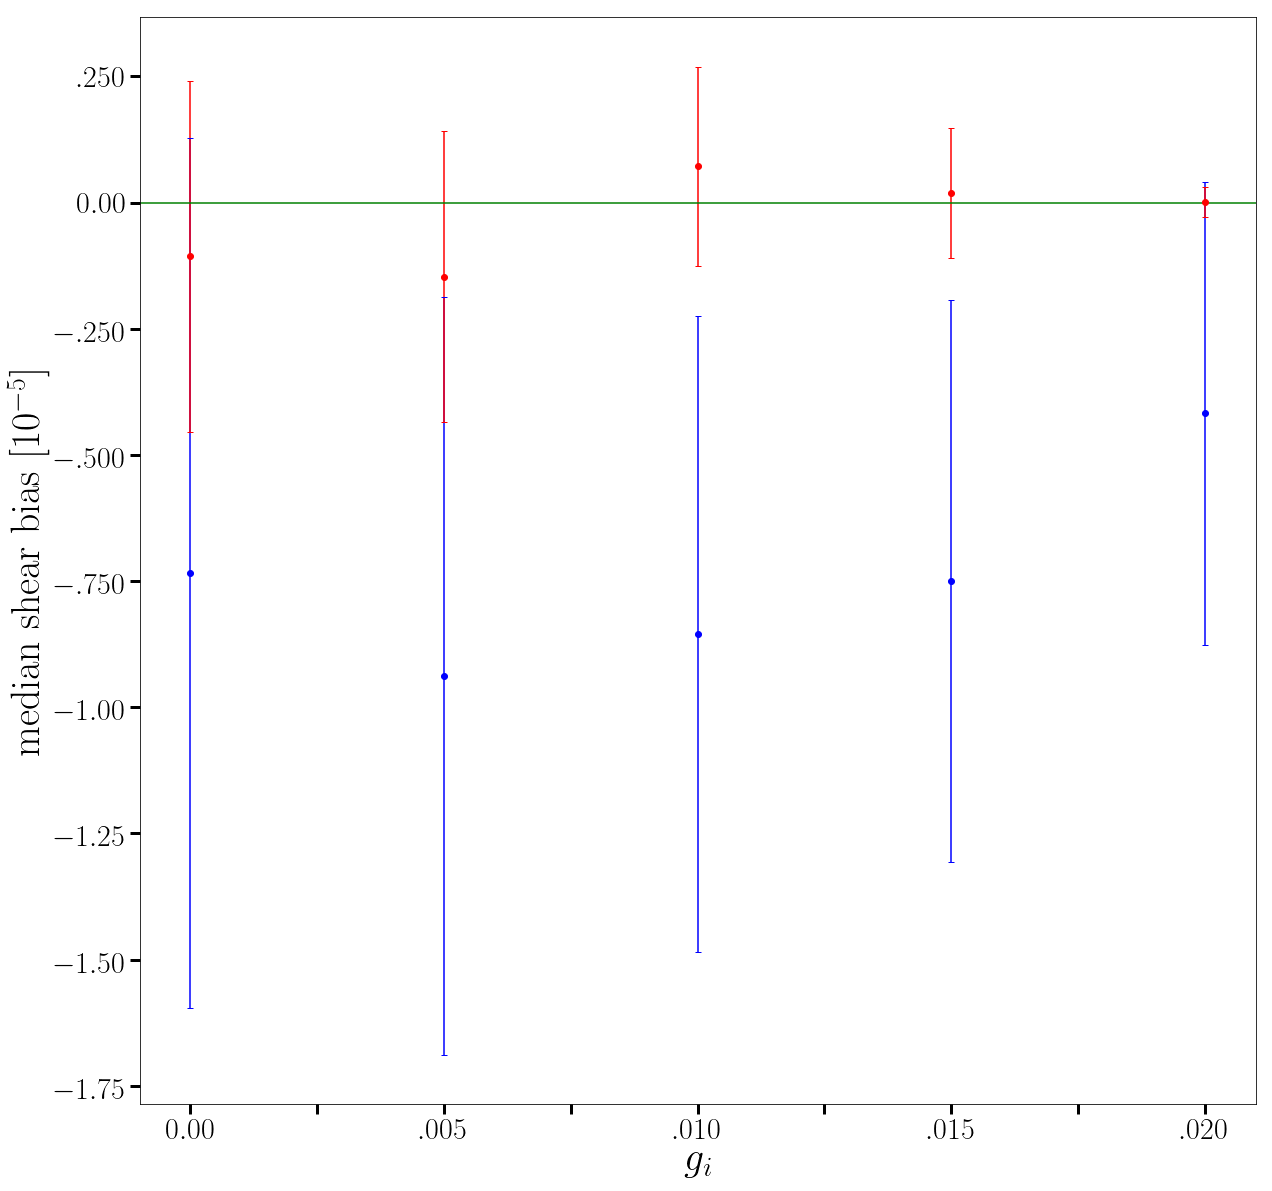

In [30]:
ticks1 = ['','$-6$', '$-4$','$-2$','$0$','$2$','$4$','$6$']
ticks2 = ['','$-1.75$','$-1.50$', '$-1.25$','$-1.00$','$-.750$','$-.500$','$-.250$','$0.00$','$.250$']
ticks3 = ['', '$0.00$','','$.005$','','$.010$','','$.015$','','$.020$']
labely1 = r'\rm median shear bias $[10^{-5}]$'

get_money_plot('g1', stds_LSSTgold_g1grp,stds_LSSTgold_g1iso,filters,main_catsLSST,ticks1,ticks2,ticks3,labely1)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgold_g2grp = sigma_med_boot(main_catsLSST,'bias_g2_grp',filters) 
stds_LSSTgold_g2iso = sigma_med_boot(main_catsLSST,'bias_g2', filters) 

In [ ]:
get_money_plot('g2', stds_LSSTgold_g2grp, stds_LSSTgold_g2iso,filters,main_catsLSST,ticks1,ticks2,ticks3,labely1)

### good galaxies 

In [52]:
filters = [good,best]

#### g1 

In [53]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgood_g1grp = sigma_med_boot(main_catsLSST,'bias_g1_grp',filters) 
stds_LSSTgood_g1iso = sigma_med_boot(main_catsLSST,'bias_g1',filters) 

just to check that symmetry is respected print both percentiles: [ -5.77513815e-05  -4.80871604e-05]
just to check that symmetry is respected print both percentiles: [ -4.37477065e-05  -3.40509578e-05]
just to check that symmetry is respected print both percentiles: [ -2.93769372e-05  -2.16140124e-05]
just to check that symmetry is respected print both percentiles: [ -1.70595431e-05  -8.99625320e-06]
just to check that symmetry is respected print both percentiles: [ -4.78459015e-06   1.03913521e-06]
just to check that symmetry is respected print both percentiles: [  3.83124780e-06   1.00830002e-05]
just to check that symmetry is respected print both percentiles: [  1.50926262e-05   2.28619610e-05]
just to check that symmetry is respected print both percentiles: [  2.92626555e-05   3.83706647e-05]
just to check that symmetry is respected print both percentiles: [  4.54490638e-05   5.65586488e-05]
just to check that symmetry is respected print both percentiles: [ -2.51144525e-05  -2.1107

medians grp: [-5.2982065e-05, -3.8960417e-05, -2.5682844e-05, -1.2918722e-05, -1.6964725e-06, 6.8656254e-06, 1.8856677e-05, 3.4010442e-05, 5.1102143e-05]
sigmas grp: [0.0047164597, 0.0046802992, 0.0047017499, 0.0046517565, 0.0046786447, 0.0046687527, 0.0046860809, 0.0046500834, 0.004683211]
errs grp: [4.8949041229207069e-06, 4.9094596761278808e-06, 4.0688319131731987e-06, 3.9224687498062849e-06, 2.7356077225704212e-06, 3.2173747968045063e-06, 4.0052836993709207e-06, 4.3602231016848236e-06, 5.4565061873290688e-06]
Beta: [  2.48281750e-03  -2.37827928e-06]
Beta Std Error: [  6.62443502e-05   8.53998897e-07]
Beta Covariance: [[  1.87619184e-02  -8.24118126e-07]
 [ -8.24118126e-07   3.11812968e-06]]
Residual Variance: 2.33894735332e-07
Inverse Condition #: 0.0130550163547
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-2.3058019e-05, -1.551121e-05, -7.9789688e-06, -3.4700315e-06, 4.0584895e-09, 2.9673874e-06, 8.9079695e-06, 1.4778283e-05, 2.3058379e-05]
sigmas iso: [0.00

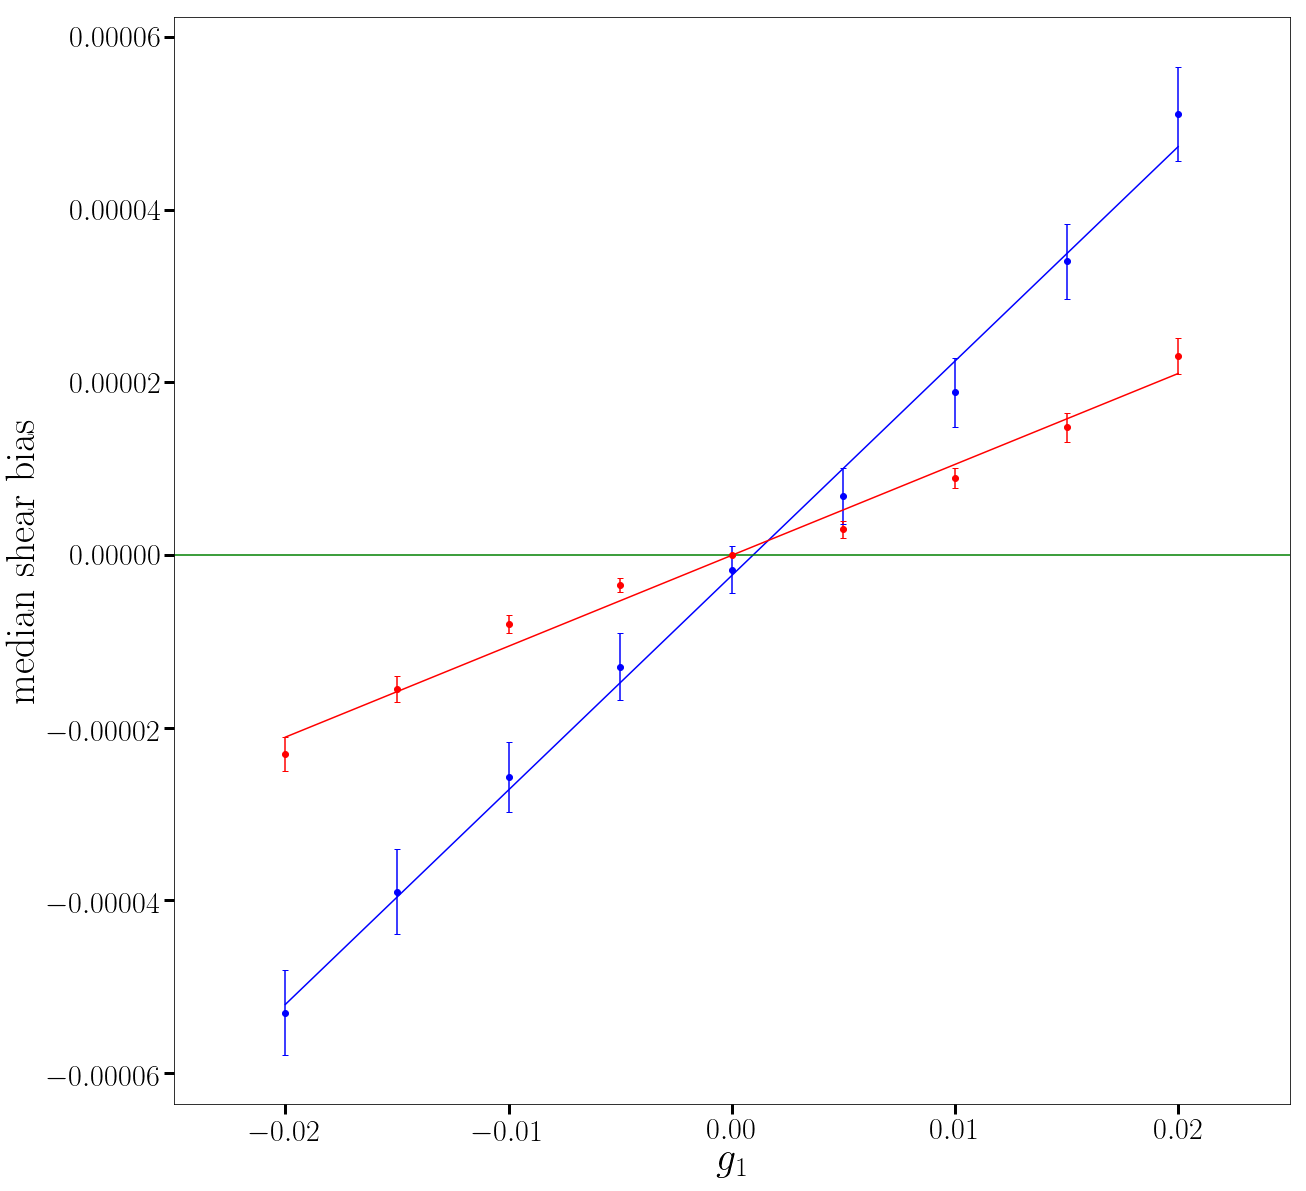

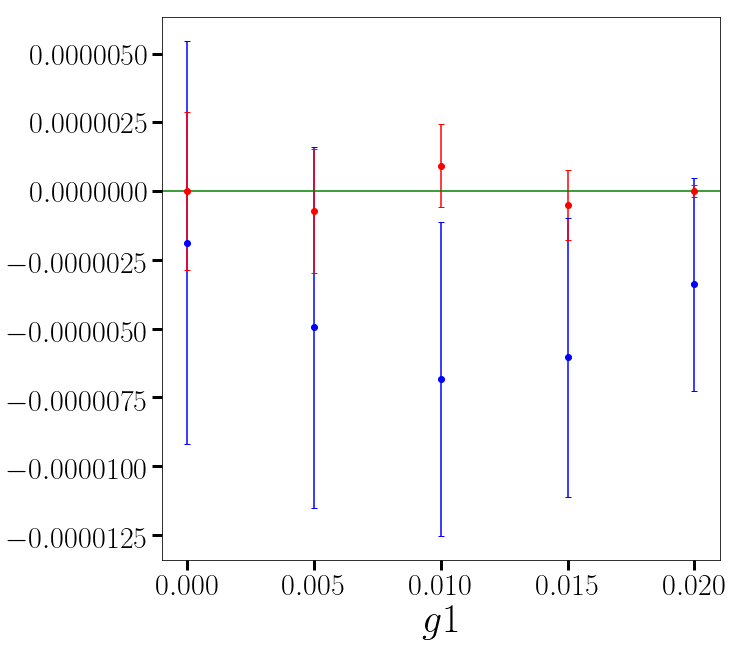

In [68]:
get_money_plot('g1', stds_LSSTgood_g1grp, stds_LSSTgood_g1iso,filters,main_catsLSST,labely1='median shear bias')

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_LSSTgood_g2grp = sigma_med_boot(main_catsLSST,'bias_g2_grp',filters) 
stds_LSSTgood_g2iso = sigma_med_boot(main_catsLSST,'bias_g2',filters) 

In [ ]:
get_money_plot('g2', stds_LSSTgood_g2grp, stds_LSSTgood_g2iso,filters,main_catsLSST)

# DES 

## Gold

In [21]:
filters = [gold,best]

#### g1

In [24]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgold_g1grp = sigma_med_boot(main_catsDES,'bias_g1_grp',filters) 
stds_DESgold_g1iso = sigma_med_boot(main_catsDES,'bias_g1',filters) 

medians grp: [-6.083382e-05, -4.3239692e-05, -3.0325526e-05, -1.9896146e-05, -1.7860621e-05, 1.9478223e-06, 1.096516e-05, 2.3857307e-05, 3.8978156e-05]
sigmas grp: [0.0050557679, 0.0050973729, 0.0051644775, 0.0052130572, 0.0051384792, 0.0050382288, 0.0051085027, 0.0051329629, 0.0050904029]
errs grp: [1.5543656e-05, 1.481764e-05, 1.6068832e-05, 1.4794075e-05, 1.4766653e-05, 1.3792296e-05, 1.4928709e-05, 1.4897316e-05, 1.6175911e-05]
Beta: [ 0.00240815]
Beta Std Error: [ 0.00030801]
Beta Covariance: [[ 0.02126463]]
Residual Variance: 4.46145857229e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.543715e-05, -9.2823739e-06, -4.2521724e-06, -1.2076104e-06, 2.5281606e-08, 3.6787555e-06, 7.4198456e-06, 1.2083221e-05, 1.6988095e-05]
sigmas iso: [0.0026806057, 0.0026587714, 0.0027063512, 0.0026739959, 0.0026560463, 0.0027038625, 0.0026652717, 0.0026803096, 0.0026562614]
errs iso: [4.1221606e-06, 3.1559425e-06, 2.1079518e-06, 1.2314691e-06, 7.794

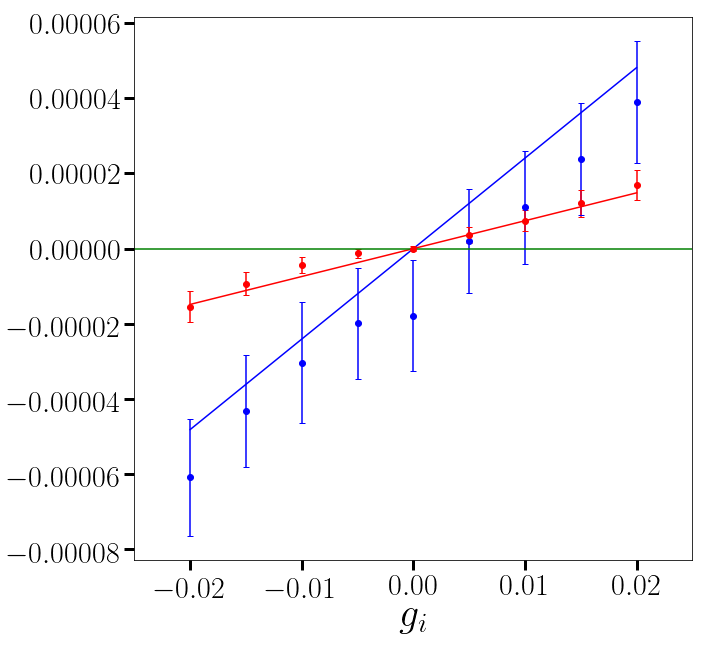

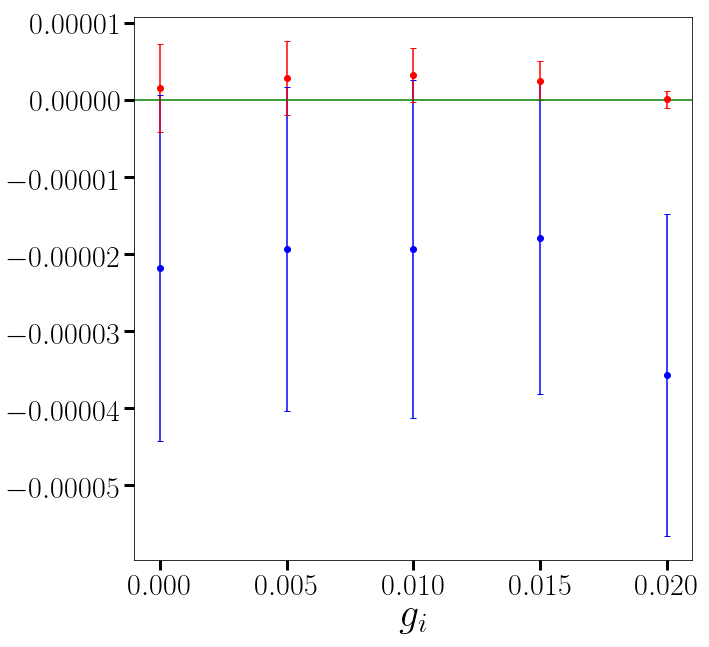

In [25]:
get_money_plot(stds_DESgold_g1grp,stds_DESgold_g1iso,filters,main_catsDES)

#### g2

In [26]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgold_g2grp = sigma_med_boot(main_catsDES,'bias_g2_grp',filters) 
stds_DESgold_g2iso = sigma_med_boot(main_catsDES,'bias_g2',filters) 

medians grp: [-4.8809266e-05, -5.3331063e-05, -3.3100583e-05, -2.3308481e-05, -8.4600324e-06, -8.5996553e-06, 7.4287959e-06, 1.9147945e-05, 3.6636287e-05]
sigmas grp: [0.005082902, 0.0050200773, 0.0050637429, 0.0051006461, 0.0050867735, 0.0050713206, 0.0050623468, 0.0051053031, 0.004978708]
errs grp: [1.711914e-05, 1.7336662e-05, 1.5518926e-05, 1.4438348e-05, 1.3799219e-05, 1.4496674e-05, 1.4229798e-05, 1.5389593e-05, 1.5893127e-05]
Beta: [ 0.00226451]
Beta Std Error: [ 0.00036924]
Beta Covariance: [[ 0.02051133]]
Residual Variance: 6.6469944466e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.5677531e-05, -1.2066728e-05, -7.5291532e-06, -4.7085073e-06, -3.6765162e-08, 1.5745287e-06, 5.387471e-06, 8.748294e-06, 1.4423226e-05]
sigmas iso: [0.0025842227, 0.002599868, 0.0026365533, 0.0026410888, 0.0025925057, 0.0025965425, 0.0026063628, 0.0026259248, 0.0026298282]
errs iso: [3.6038286e-06, 3.4319855e-06, 2.8980144e-06, 2.2094623e-06, 8.0927

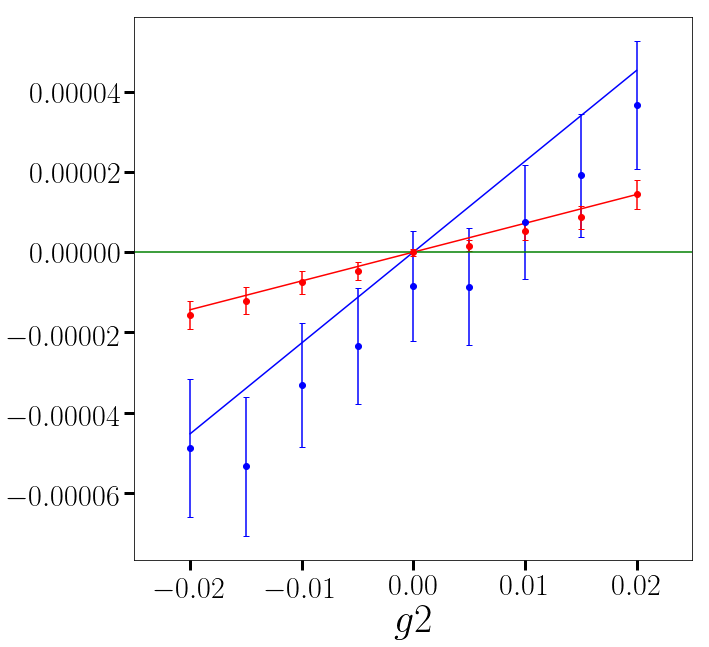

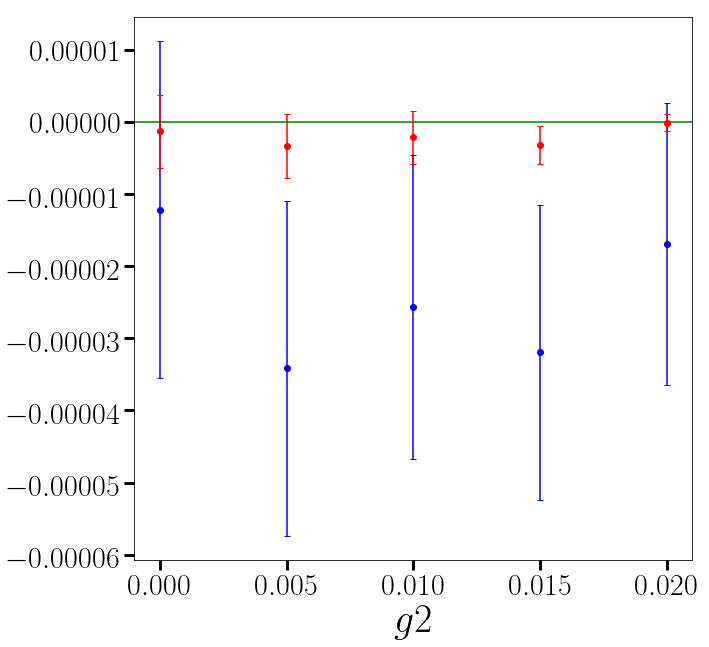

In [30]:
get_money_plot('g2',stds_DESgold_g2grp,stds_DESgold_g2iso,filters,main_catsDES)

## Good 

In [33]:
filters = [good,best]

#### g1 

In [34]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgood_g1grp = sigma_med_boot(main_catsDES,'bias_g1_grp',filters) 
stds_DESgood_g1iso = sigma_med_boot(main_catsDES,'bias_g1',filters) 

medians grp: [-5.5454911e-05, -3.9322531e-05, -2.3943405e-05, -1.7330402e-05, -1.315392e-05, 7.3715464e-06, 1.2361077e-05, 2.6055046e-05, 3.1955802e-05]
sigmas grp: [0.0039629629, 0.0039917971, 0.0040171258, 0.0039887554, 0.0039751353, 0.0039275335, 0.0039849537, 0.0039491272, 0.0039199893]
errs grp: [1.4572613e-05, 1.3676154e-05, 1.4738329e-05, 1.3939954e-05, 1.3680605e-05, 1.3804965e-05, 1.45469e-05, 1.4341525e-05, 1.5618549e-05]
Beta: [ 0.00218862]
Beta Std Error: [ 0.0002396]
Beta Covariance: [[ 0.01372234]]
Residual Variance: 4.18353671355e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.3419607e-05, -7.9706615e-06, -3.1546401e-06, -9.3657115e-07, 1.2057097e-07, 4.2439119e-06, 7.4845548e-06, 1.2561743e-05, 1.5499449e-05]
sigmas iso: [0.0019544316, 0.0019638357, 0.001995727, 0.0019646748, 0.0019408262, 0.001967703, 0.0019724355, 0.0019677882, 0.0019763138]
errs iso: [3.6167132e-06, 2.7424173e-06, 1.7890374e-06, 1.0923292e-06, 7.54720

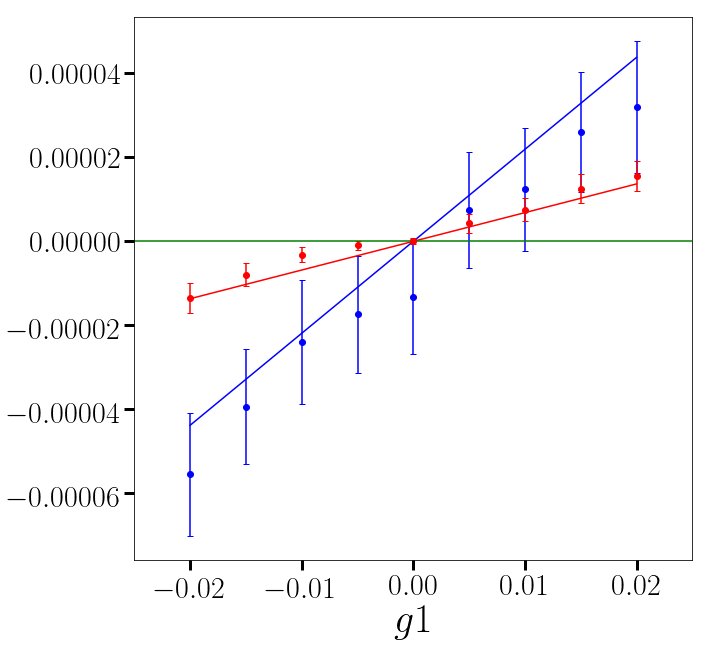

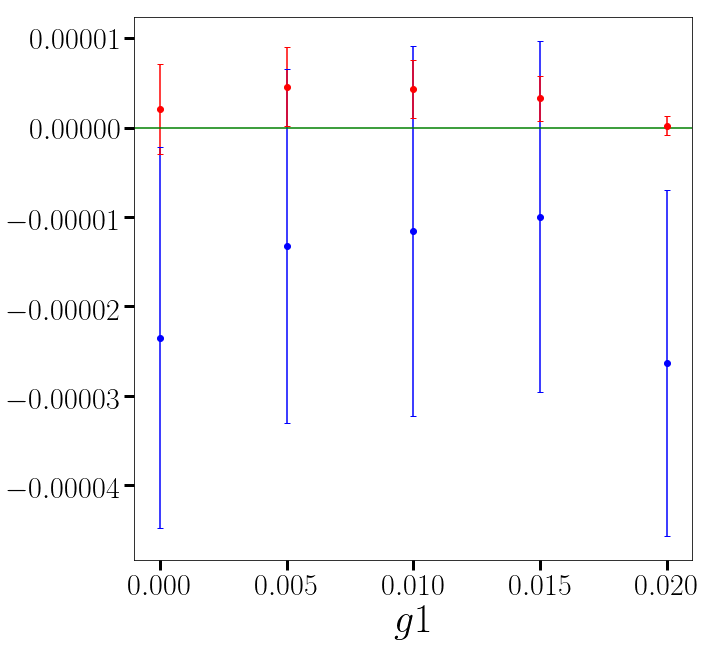

In [35]:
get_money_plot('g1', stds_DESgood_g1grp,stds_DESgood_g1iso,filters,main_catsDES)

#### g2 

In [38]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_DESgood_g2grp = sigma_med_boot(main_catsDES,'bias_g2_grp',filters) 
stds_DESgood_g2iso = sigma_med_boot(main_catsDES,'bias_g2',filters) 

medians grp: [-4.1791842e-05, -4.3822591e-05, -3.2180295e-05, -2.1160226e-05, -6.6204402e-06, -8.3041487e-06, 1.1191978e-05, 2.5774425e-05, 3.9637904e-05]
sigmas grp: [0.003898503, 0.0038673063, 0.0038861404, 0.003903287, 0.0038105808, 0.0038384744, 0.0038999671, 0.0038913353, 0.0038131732]
errs grp: [1.6161157e-05, 1.5665251e-05, 1.4705206e-05, 1.3691537e-05, 1.3075204e-05, 1.3689654e-05, 1.3676748e-05, 1.5254018e-05, 1.5529673e-05]
Beta: [ 0.00218143]
Beta Std Error: [ 0.00027959]
Beta Covariance: [[ 0.01325054]]
Residual Variance: 5.89957398474e-06
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.3941777e-05, -9.6360955e-06, -6.844607e-06, -3.9074425e-06, -1.1669465e-08, 1.8933351e-06, 5.4773755e-06, 9.578398e-06, 1.4279096e-05]
sigmas iso: [0.001856565, 0.001876912, 0.0019177868, 0.0019134633, 0.0018636324, 0.0018983085, 0.0019229609, 0.0018907761, 0.0019310936]
errs iso: [3.1081122e-06, 2.824004e-06, 2.5493796e-06, 1.9105948e-06, 7.0594

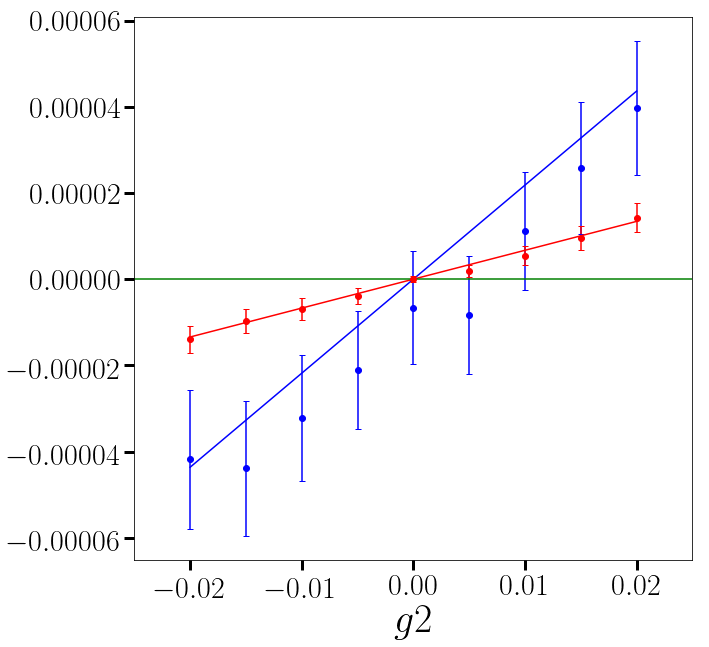

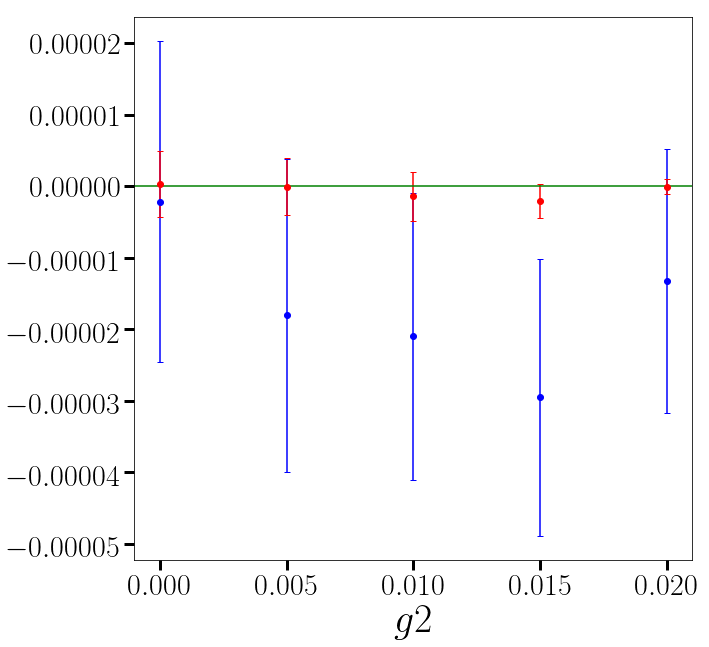

In [39]:
get_money_plot('g2', stds_DESgood_g2grp,stds_DESgood_g2iso,filters,main_catsDES)

# HSC

## Gold

In [37]:
filters = [gold,best]

#### g1 

In [38]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgold_g1grp = sigma_med_boot(main_catsHSC,'bias_g1_grp',filters) 
stds_HSCgold_g1iso = sigma_med_boot(main_catsHSC,'bias_g1',filters) 

medians grp: [-3.9297778e-05, -2.7804846e-05, -1.6934511e-05, -9.3622584e-06, -1.7282907e-06, 6.8370728e-06, 1.5727026e-05, 2.4883284e-05, 3.1090287e-05]
sigmas grp: [0.0059498413, 0.0059921006, 0.0059759575, 0.0059318412, 0.0059918473, 0.0059429104, 0.0059776627, 0.006000055, 0.0059829261]
errs grp: [5.0246849e-06, 4.2489814e-06, 3.9989459e-06, 3.2789605e-06, 2.7549145e-06, 3.0782799e-06, 3.7440486e-06, 4.2047559e-06, 4.6149698e-06]
Beta: [ 0.00173915]
Beta Std Error: [  6.35191350e-05]
Beta Covariance: [[ 0.02582223]]
Residual Variance: 1.5624832369e-07
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.7232223e-05, -1.008198e-05, -5.8150554e-06, -2.4444894e-06, 2.6429667e-11, 3.2943615e-06, 8.0385307e-06, 1.4012641e-05, 2.010246e-05]
sigmas iso: [0.0044888449, 0.0045173261, 0.0045080744, 0.0044770516, 0.0045017079, 0.0044771312, 0.0045081484, 0.0044990489, 0.0045226542]
errs iso: [2.0567863e-06, 1.5259886e-06, 1.2350799e-06, 8.85021e-07, 2.

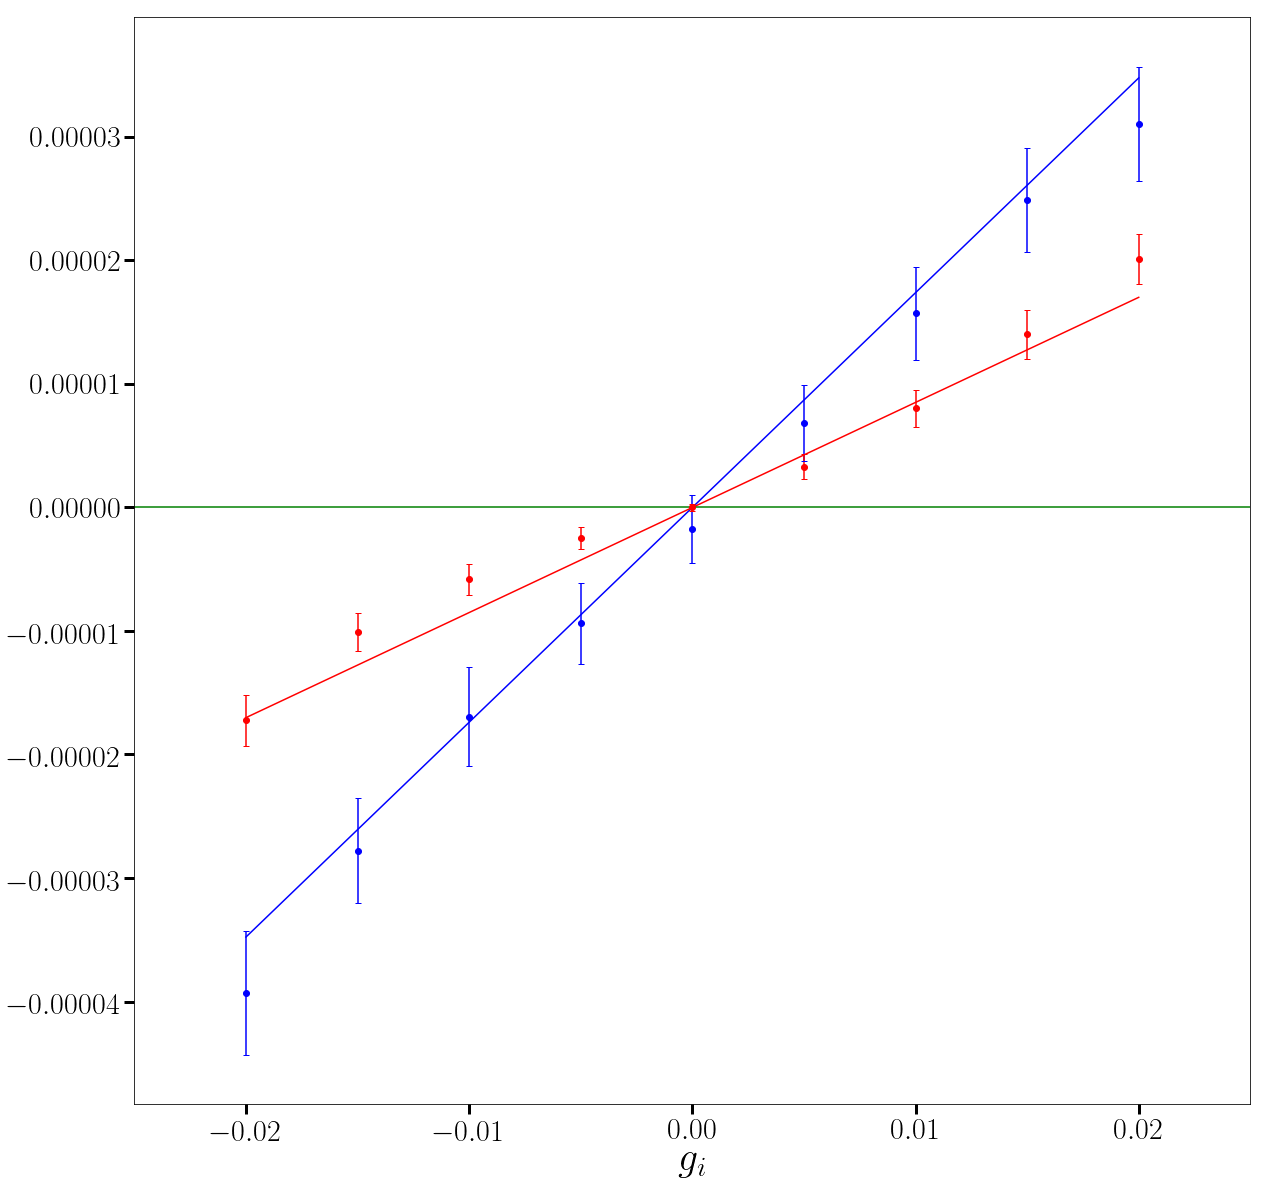

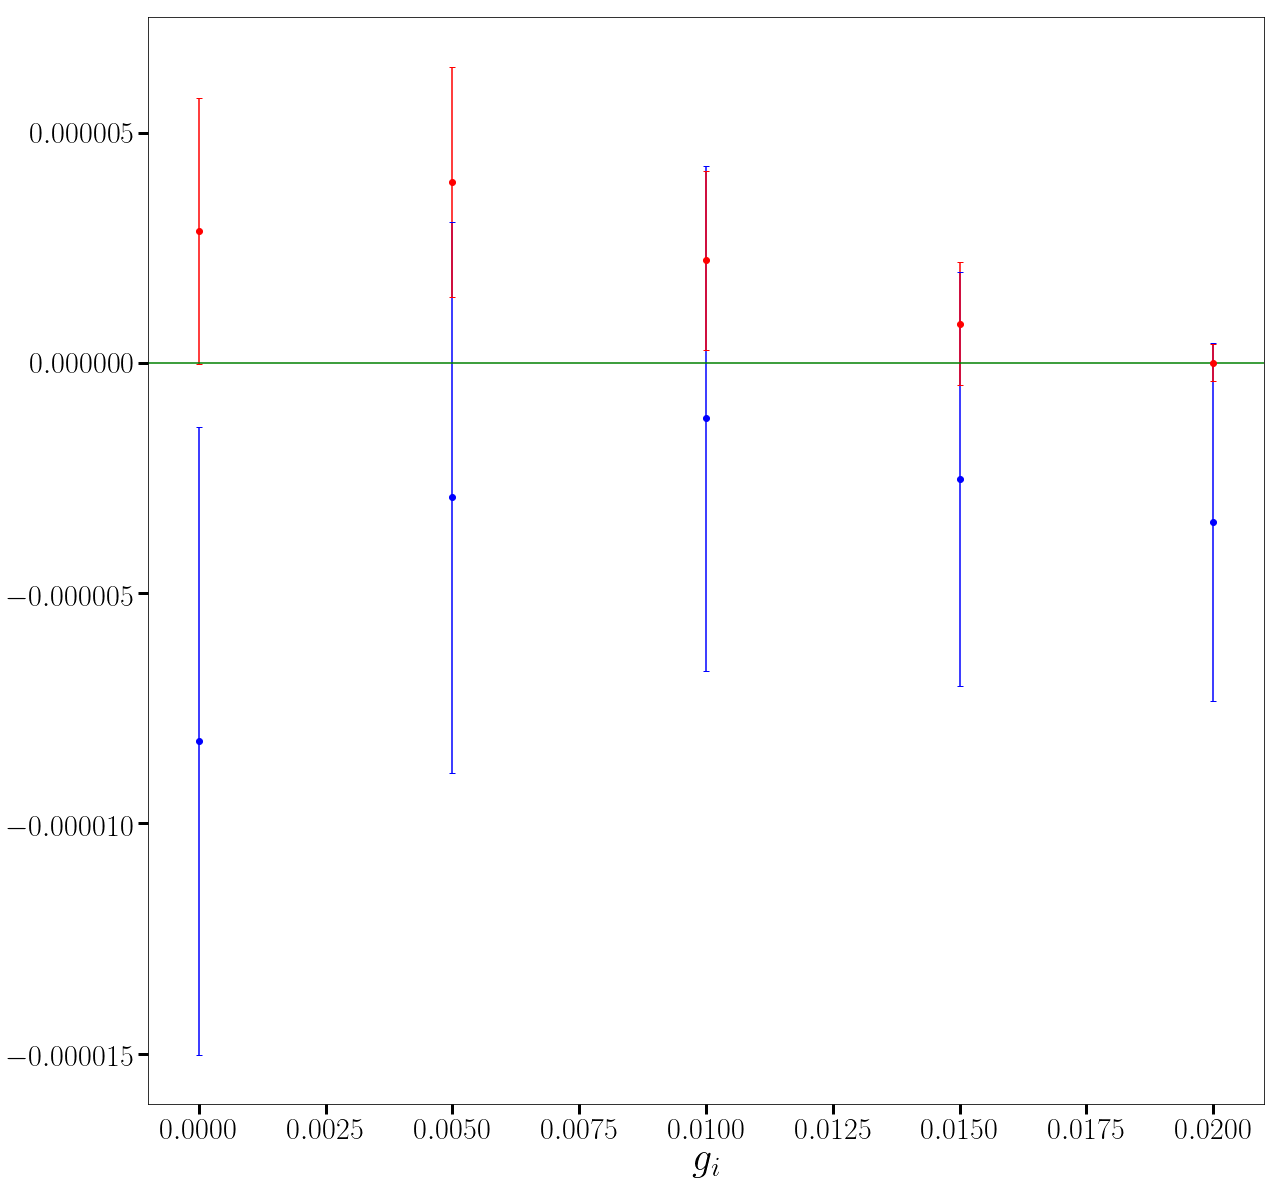

In [39]:
get_money_plot('g1', stds_HSCgold_g1grp,stds_HSCgold_g1iso,filters,main_catsHSC)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgold_g2grp = sigma_med_boot(main_catsHSC,'bias_g2_grp',filters) 
stds_HSCgold_g2iso = sigma_med_boot(main_catsHSC,'bias_g2',filters) 

In [ ]:
get_money_plot('g2',stds_HSCgold_g2grp,stds_HSCgold_g2iso,filters,main_catsHSC)

## Good 

In [40]:
filters = [good,best]

#### g1 

In [41]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgood_g1grp = sigma_med_boot(main_catsHSC,'bias_g1_grp',filters) 
stds_HSCgood_g1iso = sigma_med_boot(main_catsHSC,'bias_g1',filters) 

medians grp: [-2.6274025e-05, -1.6921598e-05, -1.0513997e-05, -6.1388409e-06, -3.5439562e-08, 5.9420036e-06, 1.1555741e-05, 1.7475477e-05, 2.3183493e-05]
sigmas grp: [0.0027864773, 0.0028028633, 0.0027924096, 0.0027972078, 0.0028140338, 0.0027995664, 0.0028023976, 0.0028189735, 0.002808433]
errs grp: [3.5425237e-06, 3.4722195e-06, 2.9307757e-06, 2.6737887e-06, 2.4208018e-06, 2.6353002e-06, 3.1154882e-06, 3.379849e-06, 3.472288e-06]
Beta: [ 0.00119197]
Beta Std Error: [  2.83452517e-05]
Beta Covariance: [[ 0.00617946]]
Residual Variance: 1.30020024637e-07
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
medians iso: [-1.0503341e-05, -5.943999e-06, -3.2926325e-06, -1.3680257e-06, 6.8840507e-08, 2.4525409e-06, 5.6402473e-06, 9.2367254e-06, 1.3948767e-05]
sigmas iso: [0.0019432416, 0.001943793, 0.0019469515, 0.0019405945, 0.0019430686, 0.0019349564, 0.0019406102, 0.0019458215, 0.0019538151]
errs iso: [1.4197554e-06, 1.09825e-06, 8.6974666e-07, 5.9315721e-07, 2.7

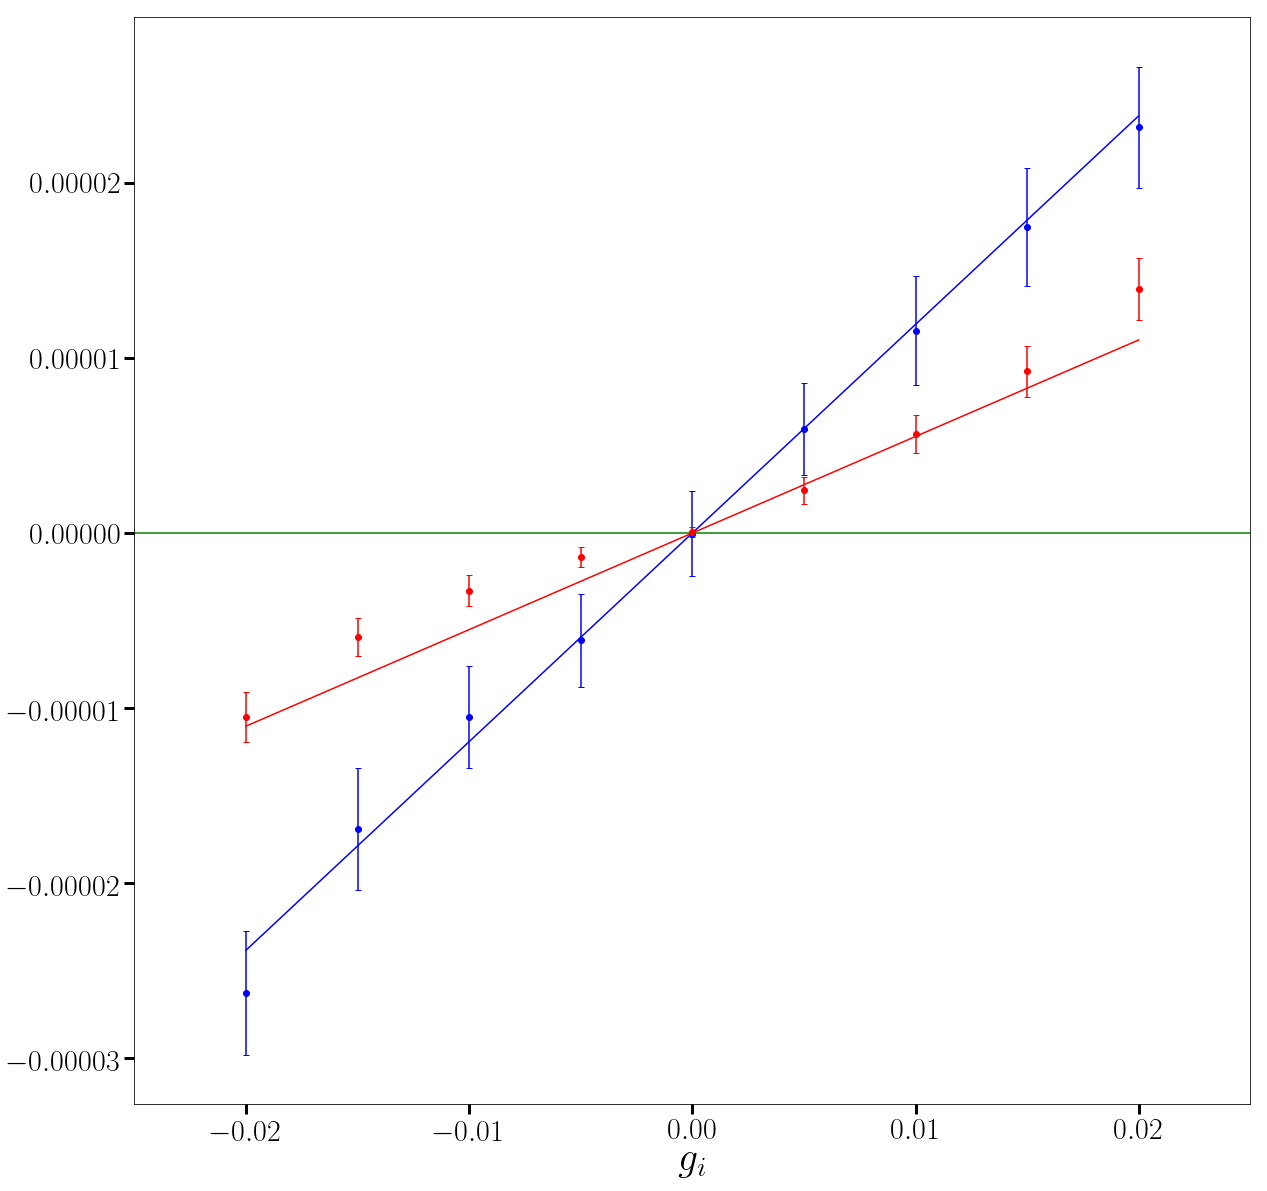

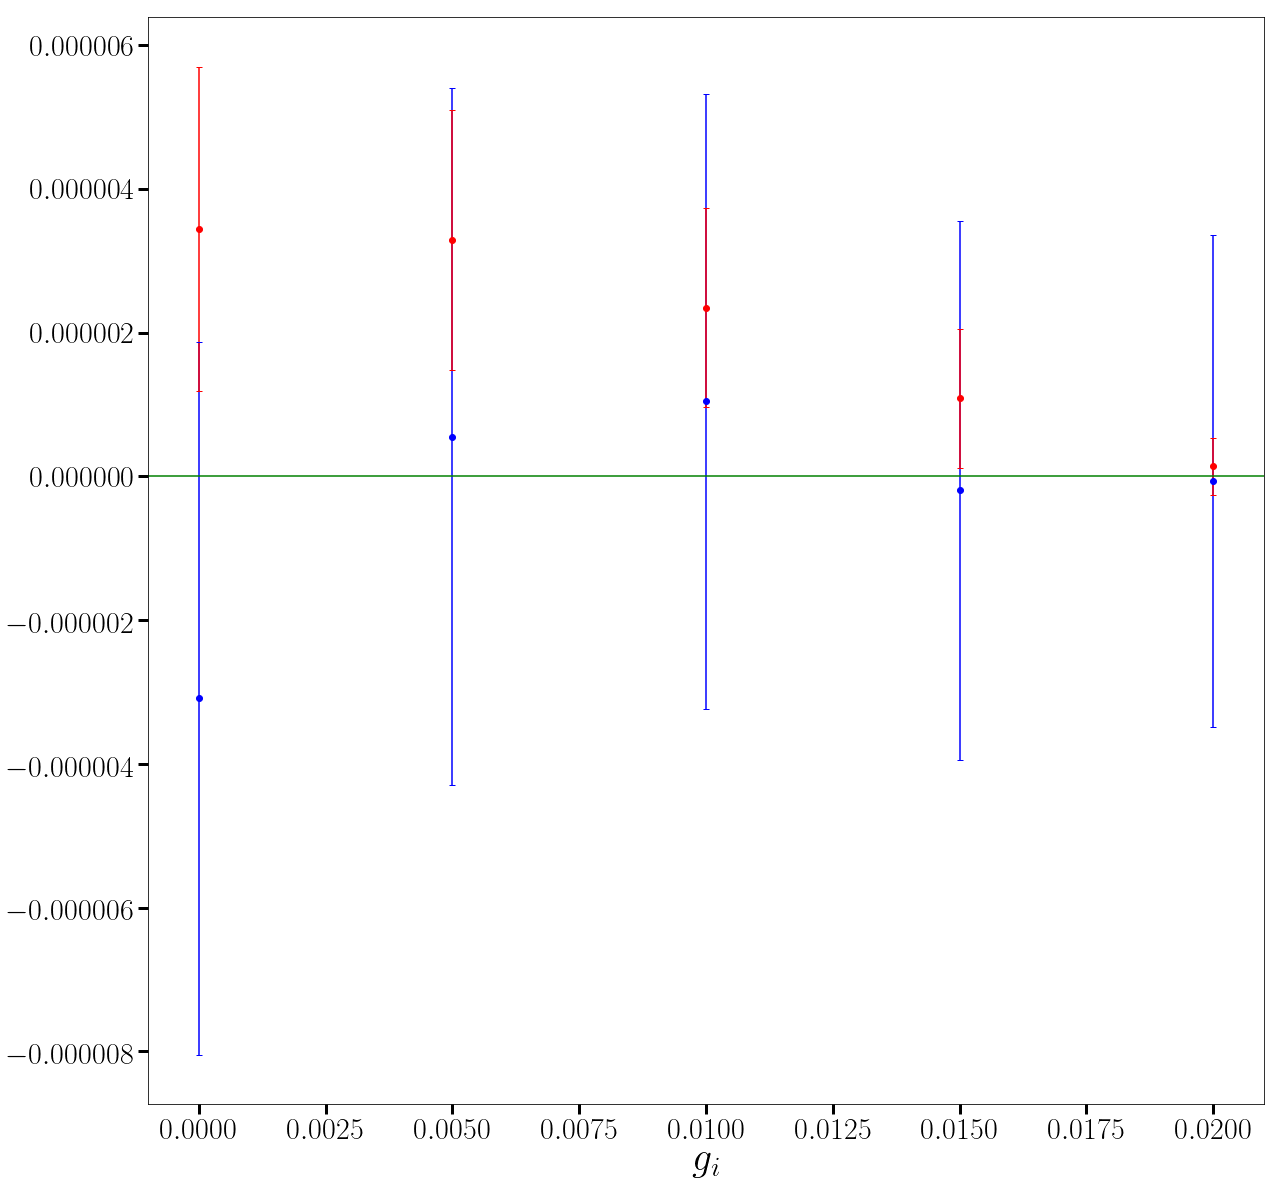

In [42]:
get_money_plot('g1', stds_HSCgood_g1grp,stds_HSCgood_g1iso,filters,main_catsHSC)

#### g2 

In [ ]:
#use bootstrap to estimate the standard deviation of the median of the distribution 
stds_HSCgood_g2grp = sigma_med_boot(main_catsHSC,'bias_g2_grp',filters) 
stds_HSCgood_g2iso = sigma_med_boot(main_catsHSC,'bias_g2',filters) 

In [ ]:
get_money_plot('g2', stds_HSCgood_g2grp,stds_HSCgood_g2iso,filters,main_catsHSC)

## Histogram of Bias 

In [246]:
#produce different plots with the biases calculated from the fisher formalism. 
def shear_biases_plots2(cat,good,gold,save=None):

    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 1,1
    #
    plt.subplot(nrow, ncol, 1) 
    plt.xlabel('$b[g_{1}]$',fontsize=25)




    plt.ylabel('Fraction of galaxies',fontsize=25)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlim(g_min,g_max)





#     plt.tick_params(axis='both', which='minor',size=5)
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_all',color='red',weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g1_grp_all',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(good['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g1_good',color='blue',weights=np.ones_like(good['bias_g1'])/len(good['bias_g1']))
    plt.hist(good['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='blue',histtype='step',label='bias_g1_grp_good',weights=np.ones_like(good['bias_g1_grp'])/len(good['bias_g1_grp']))
    plt.legend()
    plt.yscale('log')
    #
    plt.hist(gold['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g1_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g1']))
    plt.hist(gold['bias_g1_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='gold',histtype='step',label='bias_g1_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g1_grp']))
    plt.legend(prop={'size':15})
    plt.yscale('log')
    #
#     #
#     plt.subplot(nrow, ncol, 2) 
#     plt.tick_params(axis='both', which='minor',size=5)
#     plt.title('biases on g2',fontsize=14)
#     plt.xlabel('bias on g2',fontsize=14)
#     plt.ylabel('Fraction of galaxies',fontsize=14)
#     plt.xlim(g_min,g_max)
#     #
#     plt.hist(cat['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_all',color='red',weights=np.ones_like(cat['bias_g2'])/len(cat['bias_g2']))
#     plt.hist(cat['bias_g2_grp'],range=[g_min,g_max],bins=100,ls='dashed',color='red',histtype='step',label='bias_g2_grp_all',weights=np.ones_like(cat['bias_g2_grp'])/len(cat['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')
#     #
#     plt.hist(good['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',label='bias_g2_good',color='blue',weights=np.ones_like(good['bias_g2'])/len(good['bias_g2']))
#     plt.hist(good['bias_g2_grp'],range=[g_min,g_max],bins=100,color='blue',ls='dashed',histtype='step',label='bias_g2_grp_good',weights=np.ones_like(good['bias_g2_grp'])/len(good['bias_g2_grp']))
#     plt.legend()
#     #
#     plt.hist(gold['bias_g2'],range=[g_min,g_max],bins=100,histtype='step',color='gold',label='bias_g2_gold',weights=np.ones_like(gold['bias_g1'])/len(gold['bias_g2']))
#     plt.hist(gold['bias_g2_grp'],range=[g_min,g_max],bins=100,color='gold',ls='dashed',histtype='step',label='bias_g2_grp_gold',weights=np.ones_like(gold['bias_g1_grp'])/len(gold['bias_g2_grp']))
#     plt.legend()
#     plt.yscale('log')

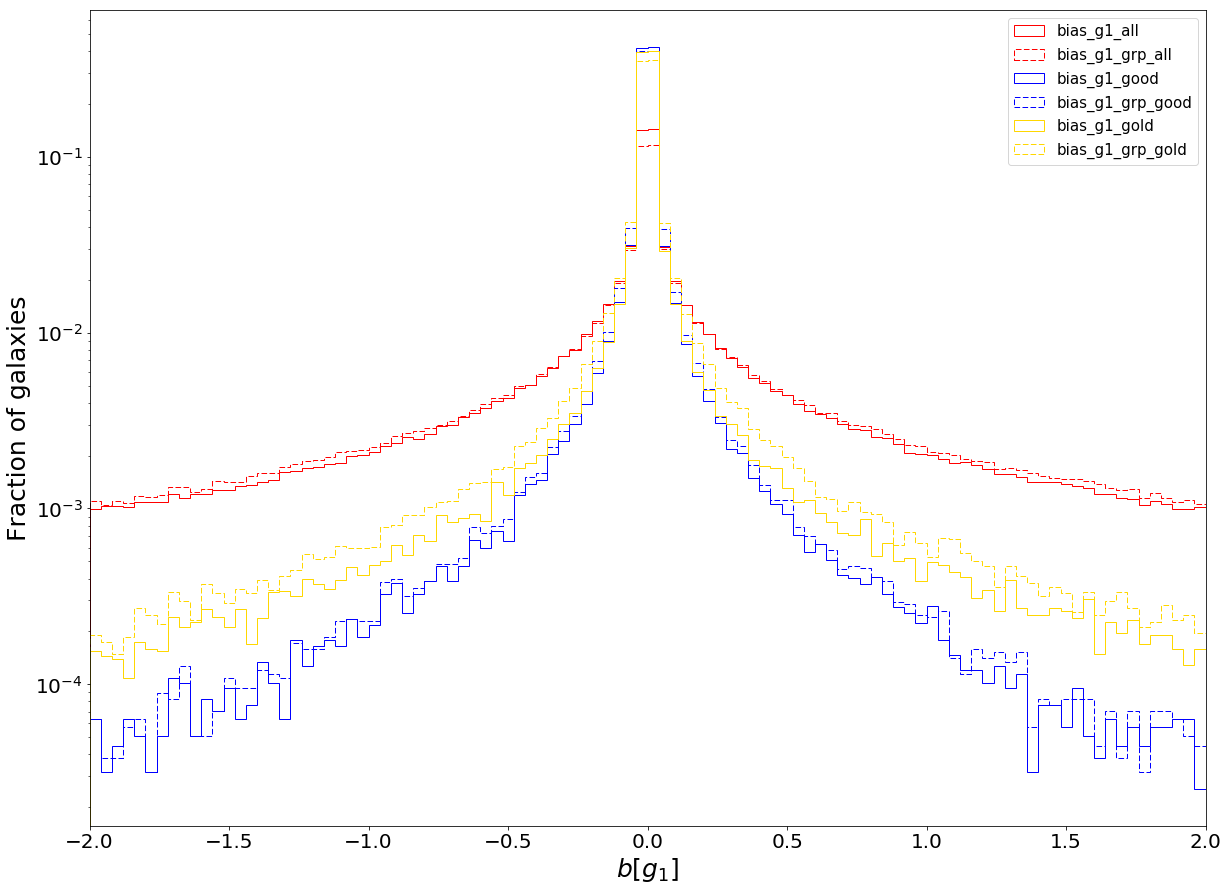

In [247]:
cat_plot = main_cats[0]
shear_biases_plots2(cat_plot,good(cat_plot),gold(cat_plot))

## Histograms of ab_mag 

In [21]:
def histograms_abmag(cat,good):
    plt.rc('text', usetex=True)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    
#     norm= 1./len(cat['ab_mag'])
#     weights = [norm] * len(good['ab_mag'])
    plt.hist(cat['ab_mag'], histtype='step', bins=50,color='blue',label='all galaxies',range=(14,30))
    plt.hist(good['ab_mag'], histtype='step',bins=50,color='red',label='good galaxies',range=(14,30))

    
    
    plt.ylabel(r'\rm Number of galaxies $[10^5]$', fontsize=25)
    plt.xlabel(r'\rm mag$_{AB}$',fontsize=25)
#     plt.title('Histogram of ab_mag for good galaxies')
    plt.legend(loc=2,prop={'size':18})
    plt.axvline(25.3,color='green',label='cut for golden sample') #this represents the gold sample cut. 
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.get_yaxis().get_offset_text().set_size(1)
    plt.savefig('/Users/Ismael/Desktop/hist_new.pdf')



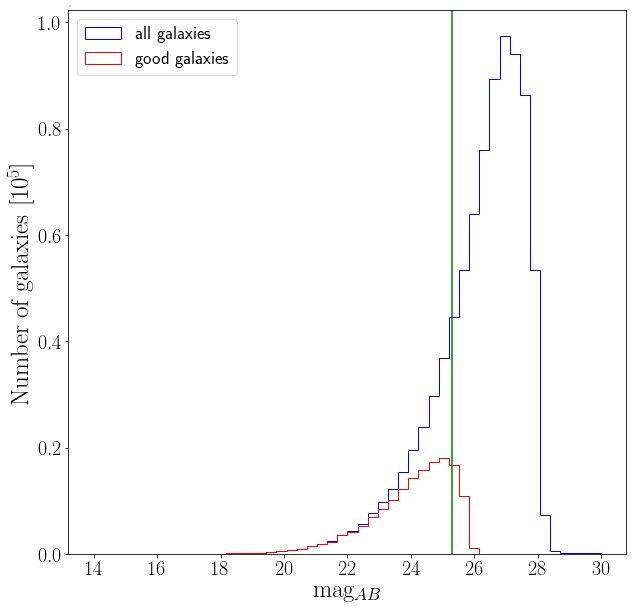

In [22]:
histograms_abmag(main_catsLSST[4],good(main_catsLSST[4]))

In [17]:
gomain_catsLSST[4]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402713998325,402713998325,1,0,1,1485,1494,1101,1109,1.0,0.0,-1501.99,-1578.92,1.49312,27.3272,0.0270901,8338.42,0.170374,0.170588,0.0345457,0.00794653,0.176525,0.164438,0.113048,0.641488,1.0,2.59592,2.59434,2.59434,1.73408,1.73408,2.45314,2.35999,2.35562,2.45314,2.35999,2.35562,0.375791,0.0682352,0.0271792,0.0,0.0,4966.54,-9.57204,1.27766,0.311511,-0.00023215,0.00138919,4966.54,-9.57204,1.27766,0.311511,-0.00023215,0.00138919,-1,False
402707721988,402707721988,1,0,1,1487,1499,1114,1124,1.0,0.0,-1501.28,-1576.07,1.52474,26.491,0.157679,18011.2,0.22733,0.295196,0.500313,0.0716952,0.396615,0.1303,0.0711658,0.681381,1.0,5.21961,5.21373,5.21373,3.48912,3.48912,1.67922,1.62573,0.682384,1.67922,1.62573,0.682384,0.407154,0.789283,0.112469,0.0,0.0,2208.33,-4.02774,4.96846,0.711635,0.000293891,-0.000328476,2208.33,-4.02774,4.96846,0.711635,0.000293891,-0.000328476,-1,False
402711568059,402711568059,2,0,1,1572,1583,1178,1189,1.0,0.0,-1484.44,-1563.24,1.35943,26.9096,0.159372,12249.1,0.408364,0.419309,0.0332133,0.159187,0.481174,0.346571,0.682552,0.745282,0.998006,2.91019,2.90865,2.90865,1.7123,1.70975,1.01866,0.832805,0.893748,1.01984,0.8338,0.894387,0.478294,0.0574526,0.298292,0.0,0.0,5858.1,-0.653572,0.0955604,0.456785,-0.00183561,-0.000535614,5616.7,-0.686878,0.0631965,0.439216,0.00390212,0.00131826,-1,False
402715332898,402711568059,2,1,1,1564,1572,1176,1183,1.0,0.0,-1486.23,-1563.93,1.18372,27.6657,0.313395,6104.67,0.136857,0.160913,0.347882,-0.198756,0.209216,0.0895237,-0.259537,0.63868,0.995544,1.94413,1.94322,1.94322,1.28485,1.28303,7.7406,6.90396,5.03739,7.74518,6.90443,5.04208,0.361459,0.447246,-0.248901,0.0,0.0,7790.59,-96.759,95.3113,-54.3095,-0.00464276,0.010914,7761.15,-96.9022,95.3174,-54.4598,-0.00626697,0.0106381,-1,False
402709443937,402709443937,2,0,1,1527,1536,1175,1185,1.0,0.0,-1493.58,-1563.95,1.81231,26.5064,0.0082531,17757.9,0.0921419,0.0931991,0.078341,0.0726009,0.10257,0.0827738,0.373694,0.625374,0.995744,5.92798,5.91921,5.91921,4.25337,4.18707,2.71251,2.68605,2.67316,2.74415,2.72226,2.67934,0.356969,0.135788,0.120434,0.0,0.0,1745.14,-16.1716,4.70215,4.36004,0.000124991,5.88133e-05,1676.79,-16.5058,4.2914,4.3692,-0.00160144,0.000766356,-1,False
402714392263,402709443937,2,1,1,1535,1543,1177,1186,0.285996,0.714004,-1492.13,-1563.57,2.72096,27.433,-0.0594025,7563.86,0.478736,0.481703,0.00384771,0.0785062,0.517967,0.442476,0.760912,0.783185,0.946024,1.62258,1.62203,1.62202,0.473352,0.467571,5.94073,2.65076,3.81424,5.98595,2.6895,3.82097,0.411185,-0.00323408,0.302383,0.0,0.0,21325.5,-2.35518,0.22639,7.619,-0.00847769,-0.00634549,20741.3,-2.75671,-0.171628,7.62668,-0.000845725,-0.00542866,-1,False
402701771027,402701771027,1,0,1,1528,1546,1136,1153,0.986968,0.0130318,-1492.49,-1570.94,0.937782,24.2447,0.553358,142586.0,0.301765,0.305207,0.0204164,0.104514,0.33581,0.271172,0.68894,0.689317,1.0,38.4611,38.1683,38.1683,25.2607,25.2607,0.0870772,0.0785147,0.0810344,0.0870772,0.0785147,0.0810344,0.437684,0.0402616,0.206315,0.0,0.0,250.278,-0.00906956,0.000631273,0.00323241,5.00208e-08,1.75922e-07,250.278,-0.00906956,0.000631273,0.00323241,5.00208e-08,1.75922e-07,1840,False
402701802864,402701802864,2,0,1,1472,1492,1149,

## Histogram for non-ambiguous blended and such, 

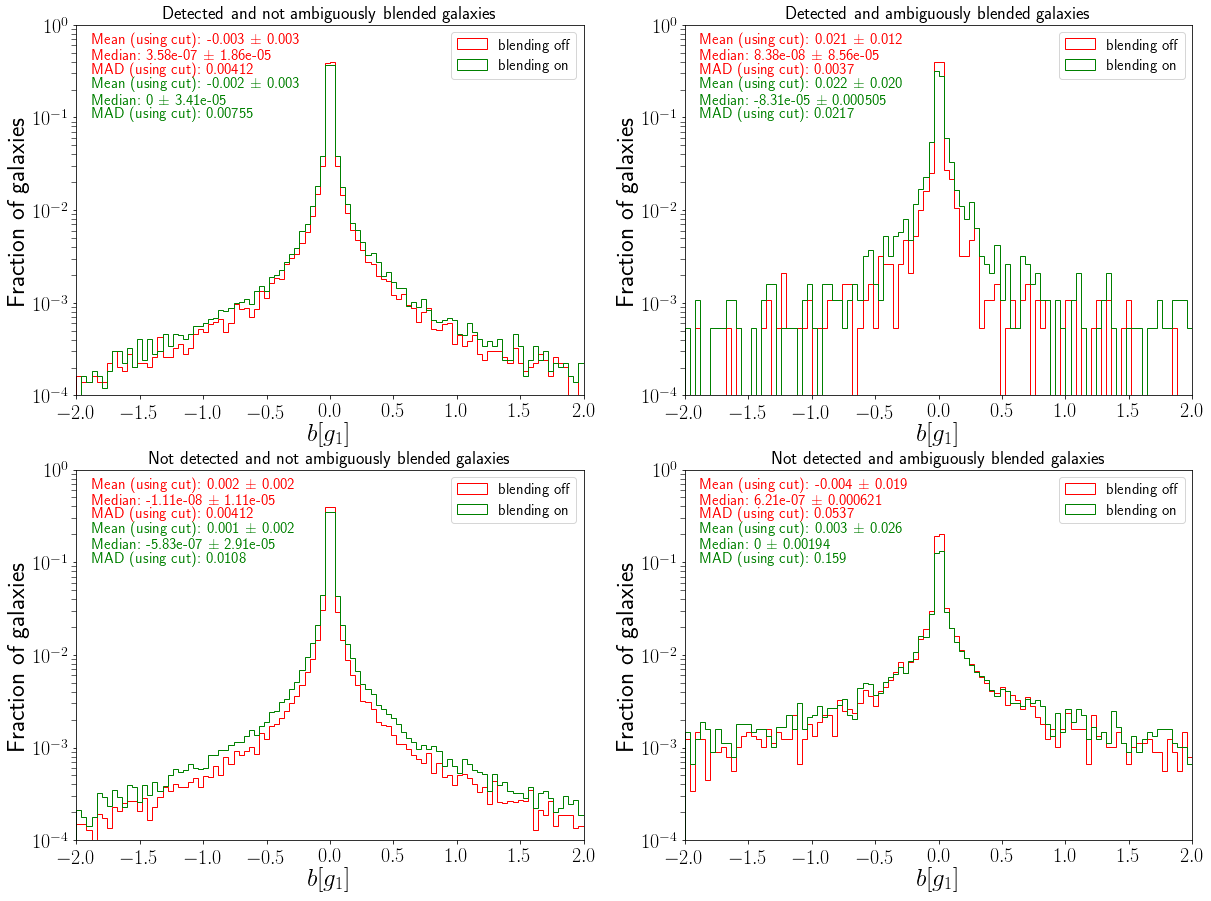

In [249]:
fig = plt.figure(figsize=(20,15))
nrow,ncol = 2,2
g_min = -2. 
g_max = 2.
names = ['Detected and not ambiguously blended galaxies','Detected and ambiguously blended galaxies','Not detected and not ambiguously blended galaxies','Not detected and ambiguously blended galaxies']

cats =[detc_and_notambig(gold(main_cats[0])),
detc_and_ambig(gold(main_cats[0])),
notdetc_and_notambig(gold(main_cats[0])),
notdetc_and_ambig(main_cats[0])]

colors = ('red','green')
for i,(cat_temp,name) in enumerate(zip(cats,names)):
    plt.subplot(nrow, ncol, i+1)
    shear_biases_hists(name,cat_temp,colors,g_min,g_max)
    plt.legend(prop={'size':15})



## Bias and covariance 

In [ ]:
#some plot from the notebook ShearEstimatorPlots using biases from the Fisher Formalism. 
#made a cut on biases for g1 and g2 in range (-2,2)
def purity_bias_shears(cat,good, gold, save=None):
    selected_cat = (cat['bias_g1'] < 2.) & (cat['bias_g1'] > -2.) & (cat['bias_g2'] < 2.) & (cat['bias_g2'] > -2.) #makes plot more feasible
    selected_good = (good['bias_g1'] < 2.) & (good['bias_g1'] > -2.) & (good['bias_g2'] < 2.) & (good['bias_g2'] > -2.)
    selected_gold = (gold['bias_g1'] < 2.) & (gold['bias_g1'] > -2.) & (gold['bias_g2'] < 2.) & (gold['bias_g2'] > -2.)
    selected_cat_grp = (cat['bias_g1_grp'] < 2.) & (cat['bias_g1_grp'] > -2.) & (cat['bias_g2_grp'] < 2.) & (cat['bias_g2_grp'] > -2.) #makes plot more feasible
    selected_good_grp = (good['bias_g1_grp'] < 2.) & (good['bias_g1_grp'] > -2.) & (good['bias_g2_grp'] < 2.) & (good['bias_g2_grp'] > -2.)
    selected_gold_grp = (gold['bias_g1_grp'] < 2.) & (gold['bias_g1_grp'] > -2.) & (gold['bias_g2_grp'] < 2.) & (gold['bias_g2_grp'] > -2.)
    g_min = -2
    g_max = 2
    fig = plt.figure(figsize=(20,15))
    nrow,ncol = 3,2
    #
    plt.subplot(nrow,ncol,1)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat[selected_cat]['purity'] >= xlo) & (cat[selected_cat]['purity'] < xhi)
        dg1 = cat[selected_cat]['bias_g1'][in_range]
        dg2 = cat[selected_cat]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.1,.6)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    ##
    plt.tight_layout()

    #
    
    plt.subplot(nrow,ncol,2)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (cat[selected_cat_grp]['purity'] >= xlo) & (cat[selected_cat_grp]['purity'] < xhi)
        dg1 = cat[selected_cat_grp]['bias_g1_grp'][in_range]
        dg2 = cat[selected_cat_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.1,.6)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.axhline(0,color='green')
    ##
    plt.tight_layout()
    #
    
    
    plt.subplot(nrow,ncol,3)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (good[selected_good]['purity'] >= xlo) & (good[selected_good]['purity'] < xhi)
        dg1 = good[selected_good]['bias_g1'][in_range]
        dg2 = good[selected_good]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.axhline(0,color='green')


    ##
    plt.tight_layout()
    #
    plt.subplot(nrow,ncol,4)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (good[selected_good_grp]['purity'] >= xlo) & (good[selected_good_grp]['purity'] < xhi)
        dg1 = good[selected_good_grp]['bias_g1_grp'][in_range]
        dg2 = good[selected_good_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    #
    
    plt.subplot(nrow,ncol,5)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (gold[selected_gold]['purity'] >= xlo) & (gold[selected_gold]['purity'] < xhi)
        dg1 = gold[selected_gold]['bias_g1'][in_range]
        dg2 = gold[selected_gold]['bias_g2'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    #
    
    
    plt.subplot(nrow,ncol,6)
    bins = np.array([0.,0.2,0.4,0.5,0.6,0.7,0.8,0.84,0.88,0.92,0.96,0.98,1.00])
    nbins = len(bins)-1
    cov = np.empty((nbins,2,2))
    n = np.empty(nbins,dtype=int)
    for i in range(nbins):
        xlo,xhi = bins[i],bins[i+1]
        in_range = (gold[selected_gold_grp]['purity'] >= xlo) & (gold[selected_gold_grp]['purity'] < xhi)
        dg1 = gold[selected_gold_grp]['bias_g1_grp'][in_range]
        dg2 = gold[selected_gold_grp]['bias_g2_grp'][in_range]
        n[i] = np.count_nonzero(in_range)
        cov[i] = np.cov(dg1,dg2)
    rms1 = np.sqrt(cov[:,0,0])
    rms2 = np.sqrt(cov[:,1,1])
    rho12 = cov[:,0,1]/(rms1*rms2)
    print rms1
    print rms2
    print rho12
    # Use Wishart distribution variances divided by (n-1)**2 to estimate errors in the covariances.
    cov_err = np.sqrt((cov**2 + np.einsum('kii,kjj->kij',cov,cov))/(n[:,np.newaxis,np.newaxis]-1.))
    x = 0.5*(bins[1:]+bins[:-1])
    dx = 0.5*(bins[1:]-bins[:-1])
    ##
    plt.errorbar(x,cov[:,0,0],yerr=cov_err[:,0,0],xerr=dx,color='b',fmt='o',label='$<\delta g_1^2>$')
    plt.errorbar(x,cov[:,1,1],yerr=cov_err[:,1,1],xerr=dx,color='r',fmt='o',label='$<\delta g_2^2>$')
    plt.errorbar(x,cov[:,0,1],yerr=cov_err[:,0,1],xerr=dx,color='k',fmt='o',label='$<\delta g_1 \delta g_2>$')
    #plt.legend()
    plt.xlim(0.,1.)
    plt.ylim(-.02,.14)
    plt.grid()
    plt.xlabel('Purity',fontsize=20)
    plt.ylabel('Bias covariance',fontsize=20)
    plt.axhline(0,color='green')
    plt.tick_params(axis='both', which='major', labelsize=15)
    ##
    plt.tight_layout()
    

# other tests 

In [5]:
results_lm = fits.open('tutorial-lmfit.fits')
results_nolm = fits.open('tutorial-nolmfit.fits')
hdr = results_lm[0].header
hdr = results_nolm[0].header
lm_cat = astropy.table.Table.read(results_lm,hdu=1)
nolm_cat = astropy.table.Table.read(results_nolm,hdu=1)

(array([   1.,    0.,    0.,    0.,    0.,    0.,  273.,    5.,    0.,    1.]),
 array([-0.17911236, -0.1529265 , -0.12674064, -0.10055478, -0.07436892,
        -0.04818306, -0.02199721,  0.00418865,  0.03037451,  0.05656037,
         0.08274623]),
 <a list of 10 Patch objects>)

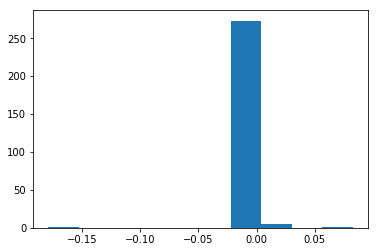

In [8]:
plt.hist(lm_cat['g1_fit']) 

In [7]:
nolm_cat

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2216998395,402700079754,17,16,1,146,155,32,40,1.0,0.0,0.251039,-22.7689,2.39188,27.9937,-0.0224438,5782.32,0.353364,0.354966,0.0670823,-0.00484534,0.377986,0.330346,-0.0360523,0.744571,0.192526,1.19193,1.19169,1.1909,0.591061,0.58829,3.5475,3.00862,2.9674,3.55627,3.0138,2.97153,0.445821,0.123976,-0.0101805,0.0,0.0
2215472133,402700079754,17,13,1,147,154,16,25,1.0,0.0,0.201267,-25.812,2.09893,27.6899,0.0378017,7649.26,0.11749,0.137468,-0.221292,-0.326797,0.178336,0.0774032,-1.08301,0.668844,0.178871,1.99434,1.99355,1.99089,1.34385,1.32477,11.6355,8.07926,9.99228,11.7059,8.11504,10.0202,0.389604,-0.384213,-0.370049,0.0,0.0
2213926551,2213926551,1,0,1,178,187,128,136,1.0,0.0,6.55618,-3.4974,1.00322,27.3562,0.559576,10401.6,0.0861867,0.0873846,0.0155106,-0.116456,0.0969839,0.0765916,-0.719193,0.66051,1.0,2.78653,2.78496,2.78496,1.9754,1.9754,8.02053,7.5906,8.08823,8.02053,7.5906,8.08823,0.388039,0.0789665,-0.138355,0.0,0.0
2206056549,2201946813,9,3,1,249,260,54,66,1.0,0.0,20.9985,-17.9942,0.618717,25.9015,0.102518,39720.4,0.0667921,0.0974112,-0.179608,0.572844,0.133655,0.0333783,0.937313,0.661854,0.934248,10.7217,10.6986,10.6979,7.8035,7.53445,12.9854,4.49464,12.4507,13.1641,4.50438,12.6031,0.391271,-0.282961,0.915862,0.0,0.0
2201946813,2201946813,9,0,1,245,263,60,77,0.752772,0.247228,20.8569,-16.231,0.591424,24.4257,0.897627,154641.0,0.146028,0.158146,0.235005,-0.155956,0.195137,0.109278,-0.292948,0.673397,0.990463,38.8139,38.5285,38.5281,21.6296,19.7846,0.449611,0.354571,0.2939,0.48779,0.382267,0.310662,0.410046,0.495583,-0.328488,0.0,0.0
2210793180,2201946813,9,6,1,234,244,68,78,0.891533,0.108467,17.9815,-15.376,2.80181,26.8029,-0.0728111,17315.7,0.128686,0.13058,-0.0280367,-0.11759,0.145308,0.113965,-0.902427,0.667588,0.987121,4.47021,4.46632,4.46631,2.97712,2.93545,2.57059,2.30475,2.44862,2.5931,2.30827,2.47839,0.402945,-0.0452887,-0.210362,0.0,0.0
2210215651,2201946813,9,7,1,241,251,61,72,0.792512,0.207488,19.2681,-16.5823,1.21718,26.7612,1.08022,17993.3,0.210959,0.212293,-0.0478464,-0.063353,0.228428,0.194826,-1.10882,0.688227,0.730456,4.26129,4.25802,4.25741,2.66169,2.43551,1.40624,1.24971,1.25741,1.50491,1.3072,1.31589,0.431357,-0.0994014,-0.12215,0.0,0.0
2211755211,2211755211,1,0,1,226,237,91,101,0.973647,0.0263529,16.3799,-10.6848,1.2193,27.0993,0.863148,13178.2,0.245656,0.26387,0.121251,-0.238122,0.323046,0.186806,-0.549909,0.705023,1.0,3.08594,3.08427,3.08427,1.987,1.987,1.83578,1.43111,1.67135,1.83578,1.43111,1.67135,0.439155,0.199341,-0.421048,0.0,0.0
2208987604,2204229736,4,1,1,251,262,138,150,1.0,0.0,21.4036,-1.1088,1.59276,26.5719,0.287687,21421.4,0.238229,0.279332,-0.179986,0.354178,0.362729,0.156461,1.02048,0.70981,0.981449,5.0403,5.03585,5.03583,3.37607,3.3626,1.41471,0.928289,1.27489,1.4251,0.934525,1.28141,0.443536,-0.298739,0.599089,0.0,0.0


## Investigate what is happening with DES g1,g2=0 

In [18]:
#median is systematically low
np.median(gold(best(main_catsDES[4]))['bias_g1_grp'])

-1.7860621e-05

In [19]:
np.median(gold(best(main_catsDES[4]))['bias_g2_grp'])

-8.4600324e-06

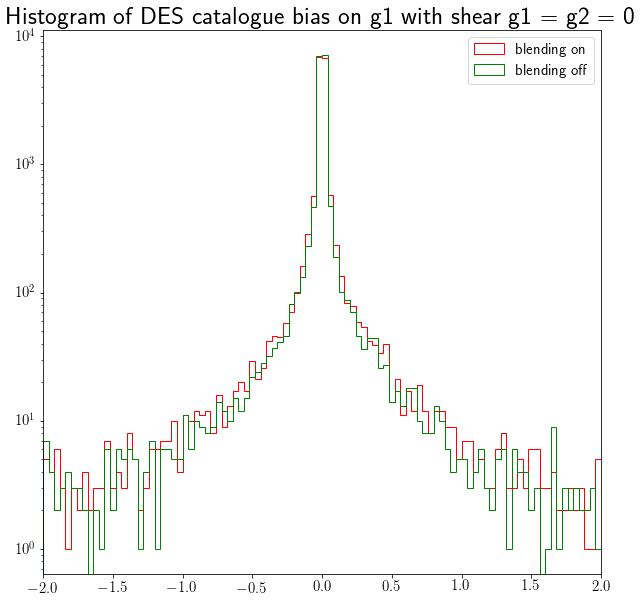

In [57]:
fig = plt.figure(figsize=(10,10))
g_min,g_max = -2,2
plt.hist(gold(best(main_catsDES[4]))['bias_g1_grp'],histtype='step',bins=100,range=[g_min,g_max],color='red',label='blending on')
plt.hist(gold(best(main_catsDES[4]))['bias_g1'],histtype='step',bins=100,range=[g_min,g_max],color='green',label='blending off')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(g_min,g_max)
plt.yscale('log')
plt.legend(prop={'size':15})
plt.title('Histogram of DES catalogue bias on g1 with shear g1 = g2 = 0',size=25)

In [46]:
#produce different plots with the biases calculated from the fisher formalism. 
plt.rc('text', usetex=True)


def shear_biases_hists(cat,colors,g_min,g_max,save=None):
    
    #plt.title(name,fontsize=18)

    plt.xlabel(r'$b[g_{1}]$',fontsize=25)


    plt.ylabel(r'\rm Fraction of galaxies',fontsize=25)
    plt.tick_params(axis='both', which='minor',size=5)
    plt.xticks(size=20)
    plt.yticks(size=20)
    
    
    plt.hist(cat['bias_g1'],range=[g_min,g_max],bins=100,histtype='step',label='blending off',color=colors[0],weights=np.ones_like(cat['bias_g1'])/len(cat['bias_g1']))
    plt.hist(cat['bias_g1_grp'],range=[g_min,g_max],bins=100,color=colors[1],histtype='step',label='blending on',weights=np.ones_like(cat['bias_g1_grp'])/len(cat['bias_g1_grp']))
    plt.yscale('log')
    plt.ylim(10e-5,10e-1)
    plt.xlim(-1.5,1.5)
    
    #print mean and stuff 
    print 'Mean bias_iso for all cat: {}'.format(np.mean(cat['bias_g1'])) 
    print 'Error on bias_iso for all cat: {}'.format(np.mean(cat['bias_g1'])) 
    mean_cut_iso = np.mean(cut_biasiso(cat,10.)['bias_g1'])
    std_cut_iso = np.std(cut_biasiso(cat,10.)['bias_g1'])
    median_iso = np.median(cat['bias_g1'])
    mad_iso = mad(cut_biasiso(cat,10.)['bias_g1'])
    error_std_iso = std_cut_iso/np.sqrt(len(cut_biasiso(cat,10)))
    error_mad_iso = mad_iso/np.sqrt(len(cut_biasiso(cat,10.)['bias_g1']))
    
    mean_cut_grp = np.mean(cut_biasgrp(cat,10)['bias_g1_grp'])
    std_cut_grp = np.std(cut_biasgrp(cat,10)['bias_g1_grp'])
    median_grp = np.median(cat['bias_g1_grp'])
    mad_grp = mad(cut_biasgrp(cat,10)['bias_g1_grp'])
    error_std_grp = std_cut_grp/np.sqrt(len(cut_biasgrp(cat,10)))
    error_mad_grp = mad_grp/np.sqrt(len(cut_biasgrp(cat,10)['bias_g1_grp']))
    
    #plt.annotate(r'Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_iso,error_std_iso), xy=(0.03, 0.95), xycoords='axes fraction',color=colors[0],fontsize=15)
    #plt.annotate(r'Median: {0:.3g} $\pm$ {1:.3g}'.format(median_iso, error_mad_iso), xy=(0.03, 0.91), xycoords='axes fraction',color=colors[0],fontsize=15)
    #plt.annotate(r'MAD (using cut): {0:.3g}'.format(mad_iso), xy=(0.03, 0.87), xycoords='axes fraction',color=colors[0],fontsize=15)
    #plt.annotate(r'Mean (using cut): {0:.3f} $\pm$ {1:.3f}'.format(mean_cut_grp,error_std_grp), xy=(0.03, 0.83), xycoords='axes fraction',color=colors[1],fontsize=15)
    #plt.annotate(r'Median: {0:.3g} $\pm$ {1:.3g}'.format(median_grp, error_mad_grp), xy=(0.03, 0.79), xycoords='axes fraction',color=colors[1],fontsize=15)
    #plt.annotate(r'MAD (using cut): {0:.3g}'.format(mad_grp), xy=(0.03, 0.75), xycoords='axes fraction',color=colors[1],fontsize=15)

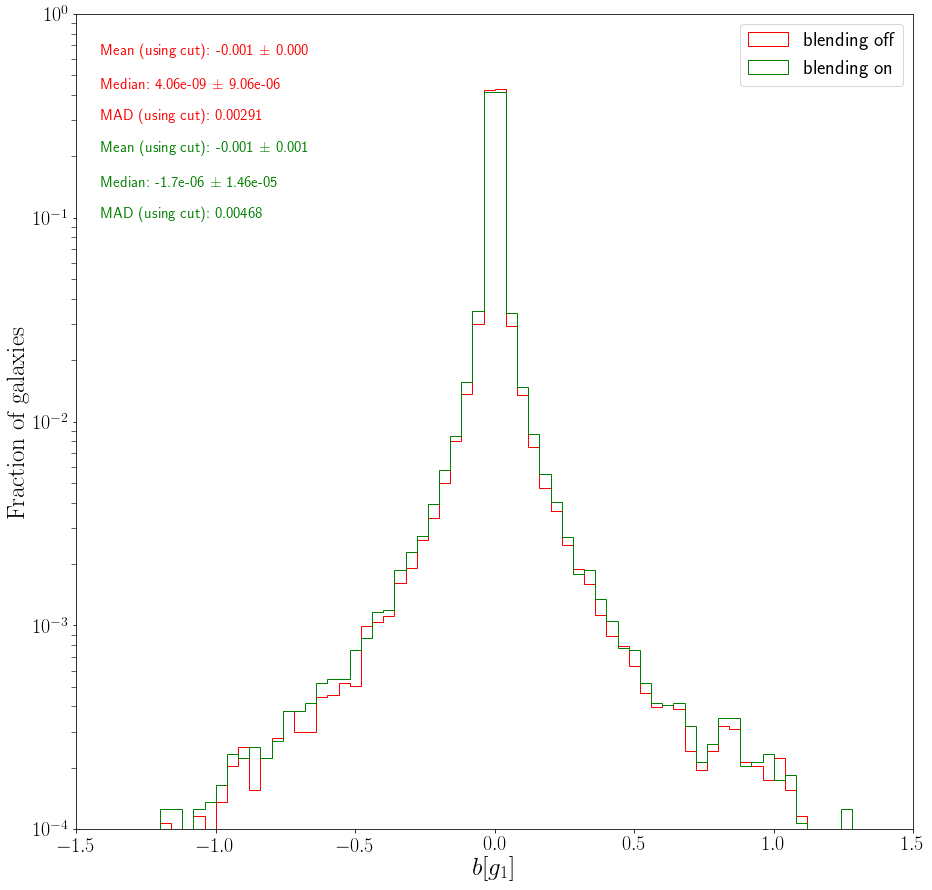

In [48]:
fig = plt.figure(figsize=(15,15))
nrow,ncol = 1,1
g_min = -2
g_max = 2


colors = ('red','green')
plt.subplot(111)
shear_biases_hists(good(best(main_catsLSST[4])),colors,g_min,g_max)
plt.legend(prop={'size':20})

plt.savefig("/Users/Ismael/Desktop/hist-medians-no-shear.pdf")




(array([   9990.,   13228.,   19319.,   32734.,  191091.,  191815.,
          32620.,   19113.,   13331.,   10268.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

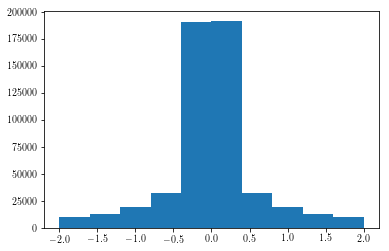

In [30]:
plt.hist(main_catsLSST[4]['bias_g1_grp'],range=(-2,2))

In [34]:
cat = good(best(main_catsLSST[4]))
len(cat[cat['bias_g1_grp'] > 2])

56

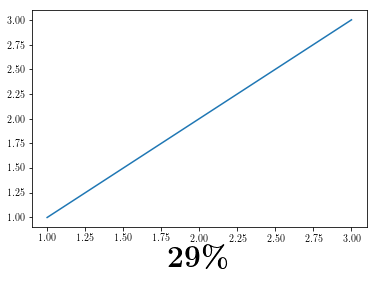

In [70]:
fig = plt.figure() 
plt.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


plt.xlabel(r'$\boldsymbol{29\%}$',size=30,)
# plt.ylabel(r'$x$',size=30)


plt.plot([1,2,3],[1,2,3])